## Compare Signature1000 velocity profiles to linear wave theory (LWT) predictions.o
ROXSI Asilomar 2022 experiment data.

In [1]:
# Imports
import os
import glob
import numpy as np 
import pandas as pd
import xarray as xr
from scipy.signal import detrend
from scipy.stats import skew
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib widget
import cmocean
from PyPDF2 import PdfWriter
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import despike as rpd
from roxsi_pyfuns import coordinate_transforms as rpct
import warnings
warnings.filterwarnings("ignore")

# Defaulkt mooring IDs and serial numbers
mids = {'103206':'L5', '103088':'C1', '103094':'C3', '103110':'C6'} # Mooring IDs from experiment
sig_mids = {'C1':'SO', 'C3':'SM', 'C6':'SI', 'L1':'SS', 'L5':'SN'} # Mooring IDs used in paper
vec_mids = {'C2':'VO', 'C3':'VM', 'C5':'VI', 'L1':'VS', 'L5':'VN'}
# Default Signature and Vector mooring ID colors
clss = {'C1':'#a70000', 'C3':'#ff5252', 'C6':'#ffbaba', 'L5':'gold'}
clsv = {'C2':'#0A369D', 'C3':'#92B4F4', 'C5':'#CFDEE7', 'L5':'darkturquoise'}
# Default paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
sigdir = os.path.join(rootdir, 'Signatures')


In [2]:
# Functions

def despike_GN02(u, interp='linear', fs=4, sec_lim=2, min_new_spikes=10, max_iter=3):
    """
    Despike Nortek Signature1000 raw beam velocity timeseries following the 
    Goring and Nikora (2002, J. Hydraul. Eng.) phase space method, 
    including the modifications by Wahl (2003, J. Hydraul. Eng.) 
    and Mori et al. (2007, J. Eng. Mech.).

    Parameters:
        u - array; 1D array with velocity time series.
        interp - str; interpolation method for discarded data.
                      Options: see pandas.DataFrame.interpolate()
        fs - scalar; sampling frequency (Hz)
        sec_lim - scalar; maximum gap size to interpolate (sec)
        min_new_spikes - int; iterate until number of new spikes detected 
                              is lower than this value. 
        max_iter - int; maximum number of despiking iterations
    
    Returns:
        ud - Despiked velocity array.
    """

    # Copy velocity array so we don't change the input
    ud = u.copy()
    # Make into pd.Series for easier interpolation
    # ud = pd.Series(ud)
    
    # Initialize counter of new spikes detected
    n_spikes = min_new_spikes + 1
    # Initialize iteraction counter
    cnt = 0
    # Iterate until sufficiently low number of new spikes detected
    while n_spikes > min_new_spikes or cnt < max_iter:
        # Detect spikes using 3D phase space method
        mask = rpd.phase_space_3d(ud.values)
        # Convert detected spikes to NaN
        if np.sum(np.isnan(mask)) > 0:
            print(f'found {np.sum(mask)} spikes')
        ud[mask] = np.nan
        # Interpolate according to requested method
        # ud.interpolate(method=interp, limit=sec_lim*fs, inplace=True)
        ud = ud.interpolate_na(dim='time').bfill('time').ffill('time')
        # Count number of spikes detected
        n_spikes = mask.sum()
        # Add to iteration counter
        cnt += 1
        if n_spikes < min_new_spikes or cnt >= max_iter:
            break

    return ud.values

def despike(ds, vel_thresh=2, **kwargs):
    """ 
    Calls despike_GN02() and despikes beam velocities in a given xr.Dataset ds.
    """
    # Copy input dataset for output
    # dso = ds.copy()
    # Beam vel. variable names in dataset
    keys = ['vB1', 'vB2', 'vB3', 'vB4', 'vB5']
    # Iterate over variables and ranges and despike
    dsl = [] # List for concatenating over time
    for k in tqdm(keys):
        print(f'Despiking {k} ...')
        # Loop over range bins
        dsl_r = [] # List for concatenating along range
        for r in ds.range.values:
            # Despike in 1h intervals
            hours = pd.date_range(pd.Timestamp(ds.time[0].values).floor('20min'), 
                                  pd.Timestamp(ds.time[-1].values).ceil('20min'), 
                                  freq='1h',
                                  )
            for t0,t1 in zip(hours[:-1], hours[1:]):
                # Take out 1-hour raw timeseries segment
                seg = ds[k].sel(range=r, time=slice(t0,t1)).copy()
                N = len(seg.values)
                if np.all(np.isnan(seg.values)):
                    # All NaN -> don't despike
                    segd = np.ones(N) * np.nan
                    print('All NaN')
                else:
                    # Apply velocity threshold and interpolate
                    seg = seg.where(((seg.values>-abs(vel_thresh)) & (seg.values<abs(vel_thresh)))).interpolate_na('time')
                    # Despike (returns np.array)
                    segd = despike_GN02(seg, **kwargs)
                # Replace original segment with despiked segment
                dsd = xr.Dataset(data_vars={k:(['time', 'range'], np.atleast_2d(segd).T),},
                                 coords={'time':('time', seg.time.values), 'range':('range', [r])},
                                 )
                # Append to list for concatenating
                dsl_r.append(dsd)
        # Concatenate over range
        dsr = xr.concat(dsl_r, dim='range')
        # Append to list for concatenating over time
        dsl.append(dsr)
    # Concatenate datasets over time
    dso = xr.concat(dsl, dim='time')

    return dso


def velocity_statistics(ds, dsa, seglen='1h', fs=4, theta=25):
    """
    ADCP beam velocity statistics estimated from beam velocities.

    Parameters:
        ds - xr.Dataset with beam velocities:
             ['vB1', 'vB2', 'vB3', 'vB4', 'vB5']
        seglen - str; segment length
        fs - float; sampling frequency (Hz)
        theta - float; beam angle to vertical (degrees)

    Returns:
        ds_out - xr.Dataset with spectra and variance for each beam 
                 velocity in input ds

    """
    thetar = np.deg2rad(theta) # Beam angle in radians
    # Define segment start/end times 
    t0 = pd.Timestamp(ds.time.values[0]).floor(seglen)
    t1 = pd.Timestamp(ds.time.values[-1]).ceil(seglen)
    seg_range = pd.date_range(t0, t1, freq=seglen)
    N = int(pd.Timedelta(seglen).total_seconds()) * fs # Samples in segment 
    # Lists for concatenating spectra
    dsd = {} # Dict for concatenated spectrum datasets
    times = [] # Spectrum timestamps
    # Iterate over beams
    print('Estimating velocity spectra ...')
    for kb in tqdm(['vB1', 'vB2', 'vB3', 'vB4', 'vB5']):
        dsl_spec = [] # List for concatenating spectra
        # Iterate over segments and estimate beam velocity spectra
        for t0s, t1s in zip(seg_range[:-1], seg_range[1:]):
            times.append(t0s) # Append time
            # Iterate over range bins
            bin_spec = [] # List to store spectra by range bin
            for rbin in ds.range.values:
                # Take out segment for current beam velocity
                seg = ds[kb].sel(time=slice(t0s,t1s), range=rbin).copy()
                # Estimate beam velocity spectrum if enough valid values
                nseg = len(seg.values) # Segment length
                # Allow max 10% NaNs
                if np.sum(np.isnan(seg.values)) < 0.2*nseg:
                    # Interpolate and estimate spectrum
                    seg_i = seg.interpolate_na(dim='time').bfill(dim='time').ffill(dim='time')
                    ds_spec = rpws.spec_uvz(detrend(seg_i.values), fs=fs)
                    # Add range to spectrum dataset
                    ds_spec = ds_spec.assign_coords(range=[rbin])
                    # print(f'ds_spec.Ezz: {ds_spec.Ezz}')
                    # Save spectrum to dataset with range coord/dim and append to list
                    spec = xr.Dataset(data_vars={'Ezz':(['freq','range'], np.atleast_2d(ds_spec.Ezz.values).T)},
                                      coords=dict(freq=(['freq'], ds_spec.freq.values),
                                                  range=(['range'], [rbin]),
                                                  ),
                                      )
                    # Also compute variance & skewness of beam velocity and add to dataset
                    var = np.var(seg_i.values)
                    spec['variance'] = (['range'], [var])
                    skew = np.skew(seg_i.values)
                    spec['skew'] = (['range'], [skew])
                    # Append spectrum to list
                    bin_spec.append(spec)
                else:
                    # Not enough good data, save array of NaNs
                    seg_dummy = np.arange(N) * np.cos(np.arange(N)) # Dummy array
                    ds_spec = rpws.spec_uvz(seg_dummy, fs=fs) # Dummy spectrum
                    nan_array = np.ones(len(ds_spec.freq.values)) * np.nan # NaN array for dataset
                    # Make empty spectrum (all NaN) and append to list
                    empty_spec = xr.Dataset(data_vars={'Ezz':(['freq','range'], np.atleast_2d(nan_array).T)},
                                            coords=dict(freq=(['freq'], ds_spec.freq.values),
                                                        range=(['range'], [rbin]),
                                                        ),
                                            )
                    # Add NaN variance to dataset
                    empty_spec['variance'] = (['range'], [np.nan])
                    empty_spec['skew'] = (['range'], [np.nan])
                    bin_spec.append(empty_spec)
            # Concatenate spectra for current beam by range
            spectral_profile = xr.concat(bin_spec, dim='range')
            # Add time coord. to spectrum dataset
            spectral_profile = spectral_profile.assign_coords(time=[t0s])
            # Add AST spectrum and variance (only once)
            if kb == 'vB1':
                ast = dsa.sel(time=slice(t0s,t1s)).copy() # AST segment
                ast_i = ast.interpolate_na(dim='time').bfill(dim='time').ffill(dim='time')
                if np.sum(np.isnan(ast_i.values)) == 0:
                    # Estimate AST spectrum
                    ds_spec_ast = rpws.spec_uvz(detrend(ast_i.values), fs=fs)
                    # Save to dataset
                    spectral_profile['AST_spec'] = (['freq', 'time'], np.atleast_2d(ds_spec_ast.Ezz.values).T)
                    spectral_profile['AST_var'] = (['time'], [np.var(ast_i.values)])
                    spectral_profile['AST_skew'] = (['time'], [np.skew(ast_i.values)])
                    # Full water depth
                    spectral_profile['depth'] = (['time'], [np.mean(ast_i.values)+0.35])
                    # LWT estimates of hor. and vertical velocity
                    m0 = rpws.spec_moment(ds_spec_ast.Ezz.values, ds_spec_ast.freq.values, 0)
                    m1 = rpws.spec_moment(ds_spec_ast.Ezz.values, ds_spec_ast.freq.values, 1)
                    fm = m1 / m0 # Mean wave freq. from AST spectrum
                    fp = rpws.peak_freq(ds_spec_ast.Ezz.values, ds_spec_ast.freq.values) # peak freq
                    spectral_profile['fm'] = (['time'], [fm])
                    spectral_profile['fp'] = (['time'], [fp])
                    # Mean/peak wavenumbers
                    km = rpws.waveno_full(2*np.pi*fm, np.mean(ast_i.values)+0.35)
                    kp = rpws.waveno_full(2*np.pi*fp, np.mean(ast_i.values)+0.35)
                    spectral_profile['km'] = (['time'], [km.item()])
                    spectral_profile['kp'] = (['time'], [kp.item()])
                else:
                    # For missing values save NaNs
                    ast_dummy = np.arange(N) * np.cos(np.arange(N)) # Dummy array
                    ds_spec_ast = rpws.spec_uvz(ast_dummy, fs=fs) # Dummy spectrum
                    nan_array = np.ones(len(ds_spec_ast.freq.values)) * np.nan # NaN array for dataset
                    spectral_profile['AST_spec'] = (['freq', 'time'], np.atleast_2d(nan_array).T)
                    spectral_profile['AST_var'] = (['time'], [np.nan])
                    spectral_profile['AST_skew'] = (['time'], [np.nan])
                    spectral_profile['depth'] = (['time'], [np.nan])
                    spectral_profile['fm'] = (['time'], [np.nan])
                    spectral_profile['km'] = (['time'], [np.nan])
                    spectral_profile['fp'] = (['time'], [np.nan])
                    spectral_profile['kp'] = (['time'], [np.nan])
            # Append to list
            dsl_spec.append(spectral_profile)
        # Concatenate spectral profiles by time
        dsd[kb] = xr.concat(dsl_spec, dim='time')

    # Compute horizontal velocity statistics. Start with u-vel. spec.
    ds_out = (dsd['vB1'].Ezz + dsd['vB3'].Ezz - 2*dsd['vB5'].Ezz*np.cos(thetar)**2) / (2*np.sin(thetar)**2)
    ds_out = ds_out.to_dataset().rename({'Ezz':'Uspec'}) # Rename first variable
    # Add v-velocity spectrum
    ds_out['Vspec'] = (dsd['vB2'].Ezz + dsd['vB4'].Ezz - 2*dsd['vB5'].Ezz*np.cos(thetar)**2) / (2*np.sin(thetar)**2)
    ds_out['Wspec'] = dsd['vB5'].Ezz * 1
    ds_out['ASTspec'] = dsd['vB1'].AST_spec * 1
    # Estimate total hor. vel. variance
    ds_out['Uvar'] = (dsd['vB1'].variance + dsd['vB3'].variance - 2*dsd['vB5'].variance*np.cos(thetar)**2) / (2*np.sin(thetar)**2)
    ds_out['Vvar'] = (dsd['vB2'].variance + dsd['vB4'].variance - 2*dsd['vB5'].variance*np.cos(thetar)**2) / (2*np.sin(thetar)**2)
    ds_out['Wvar'] = dsd['vB5'].variance * 1
    ds_out['ASTvar'] = dsd['vB1'].AST_var * 1
    ds_out['depth'] = dsd['vB1'].depth * 1
    ds_out['fm'] = dsd['vB1'].fm * 1
    ds_out['km'] = dsd['vB1'].km * 1
    ds_out['fp'] = dsd['vB1'].fp * 1
    ds_out['kp'] = dsd['vB1'].kp * 1
    
    return ds_out




Read data for desired ADCP (use serial number), perform QC on beam velocities based on beam amplitude and correlation, and compare estimated velocity statistics to LWT.

In [ ]:
# Paths etc
ser = '103110' # Signature ADCP serial number
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
sigdir = os.path.join(rootdir, 'Signatures')
datadir = os.path.join(sigdir, 'Level1', ser)
outdir = os.path.join(datadir, 'beam_vel')
if not os.path.isdir(outdir):
    os.mkdir(outdir)
# Date(s) to analyse
t0 = pd.Timestamp('2022-07-05')
# ndays = 1 # Number of days
# t1 = t0 + pd.Timedelta(days=ndays)
t1 = pd.Timestamp('2022-07-14')
# Define output velocity spectrum and variance dataset nc filename
fn_nc_out = os.path.join(sigdir, f'{ser}_vel_stats_{t0.strftime("%Y%m%d")}_{t1.strftime("%Y%m%d")}_max_amp_vel.nc')
if not os.path.isfile(fn_nc_out):
    dates = pd.date_range(t0, t1, freq='1d')
    # Perform QC on beam velocities and concatenate to one dataset
    dsl_v = [] # Empty list for concatenating QC'd beam vel. datasets
    dsl_a = [] # Empty list for concatenating despiked AST range datasets
    amp_min = 40 # Beam amplitude minimum threshold (dB)
    amp_max = 100 # Beam amplitude maximum threshold (dB)
    vel_max = 3.0 # Beam velocity maximum threshold (m/s)
    corr_thresh = 75 # Beam correlation minimum threshold (%)
    print('Beam velocity QC ...')
    for date in tqdm(dates):
        datestr = date.strftime('%Y%m%d')
        # Read beam velocity dataset for current date
        fn_nc = os.path.join(datadir, f'Asilomar_SSA_Sig_Vel_{ser}_{datestr}_v2.nc')
        dsi = xr.open_dataset(fn_nc)
        # Make masks for keeping only good values
        valid = (dsi.range < (0.9 * dsi.ASTd)) # Valid range values below surface
        good = {'B1': ((dsi.ampB1>=amp_min) & (dsi.ampB1<=amp_max) & (dsi.vB1<=vel_max) & (dsi.corrB1>=corr_thresh)), # Good Beam1 values
                'B2': ((dsi.ampB2>=amp_min) & (dsi.ampB1<=amp_max) & (dsi.vB2<=vel_max) & (dsi.corrB2>=corr_thresh)), # Good Beam2 values
                'B3': ((dsi.ampB3>=amp_min) & (dsi.ampB1<=amp_max) & (dsi.vB3<=vel_max) & (dsi.corrB3>=corr_thresh)), # Good Beam3 values
                'B4': ((dsi.ampB4>=amp_min) & (dsi.ampB1<=amp_max) & (dsi.vB4<=vel_max) & (dsi.corrB4>=corr_thresh)), # Good Beam4 values
                'B5': ((dsi.ampB5>=amp_min) & (dsi.ampB1<=amp_max) & (dsi.vB5<=vel_max) & (dsi.corrB5>=corr_thresh)), # Good Beam5 values
                }
        keys = ['vB1', 'vB2', 'vB3', 'vB4', 'vB5'] # Keys for beam vel.
        # Only keep valid/good beam velocities
        good_vb = dsi[keys].where((valid & good['B1'] & good['B2'] & good['B3'] & good['B4'] & good['B5'])).copy()
        # Despike beam velocities with phase-space method
        # good_vb_desp = despike(good_vb, max_iter=1, vel_thresh=2)
        # Append to lists for concatenating
        # dsl_v.append(good_vb_desp)
        dsl_v.append(good_vb)
        dsl_a.append(dsi.ASTd)
    # Concatenate QC'd beam vel. datasets
    dsv = xr.concat(dsl_v, dim='time')
    dsa = xr.concat(dsl_a, dim='time')

    # Estimate velocity statistics for beam velocities and save to netcdf
    dss = velocity_statistics(dsv, dsa)
    # Save to netcdf
    dss.to_netcdf(fn_nc_out)
else:
    # Read premade file
    dss = xr.open_dataset(fn_nc_out, decode_coords='all')


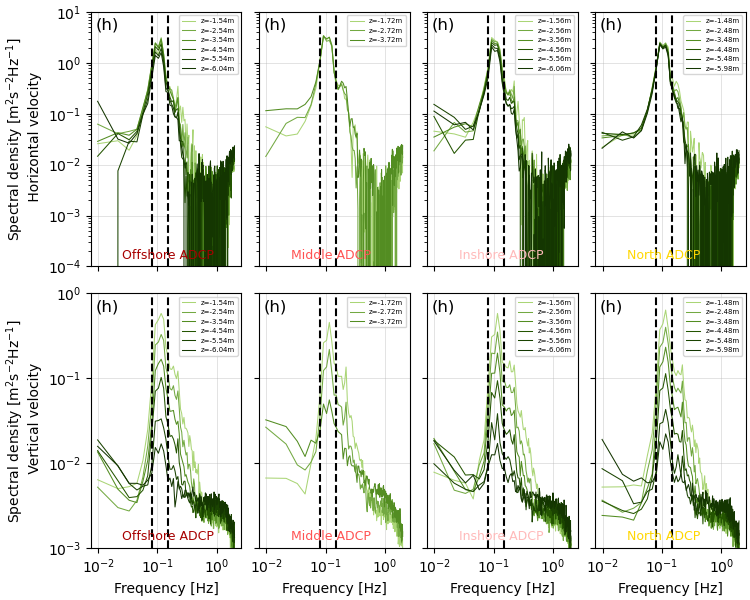

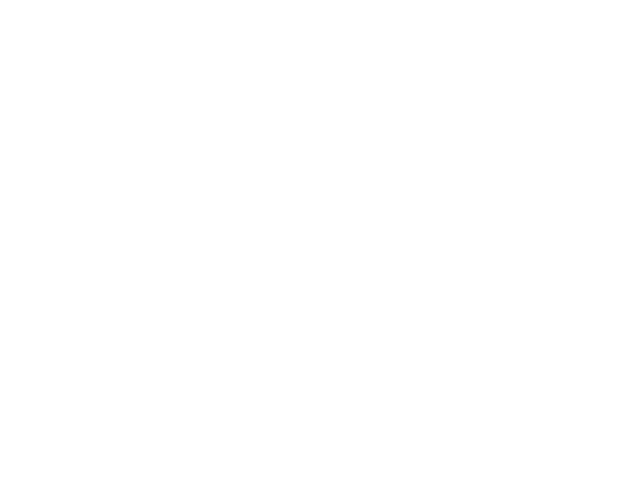

In [53]:
import matplotlib.ticker as ticker
plt.close(); plt.clf()
# Paths etc
sers = ['103088', '103094', '103110', '103206']
annot = {'SO':'Offshore ADCP', 'SM':'Middle ADCP', 'SI':'Inshore ADCP', 'SN':'North ADCP'}
abc = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', ]
fig, axes = plt.subplots(figsize=(7.5,6), ncols=len(sers), nrows=2, constrained_layout=True, sharex=True, sharey='row')
for i,ser in enumerate(sers):
    mid = mids[ser]
    loc = sig_mids[mid]
    ann = annot[loc]
    rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
    sigdir = os.path.join(rootdir, 'Signatures')
    datadir = os.path.join(sigdir, 'Level1', ser)
    # Date(s) to analyse
    t0 = pd.Timestamp('2022-07-05')
    t1 = pd.Timestamp('2022-07-14')
    # Frequency range
    fmin = 0
    fmax = 2
    # Times + range bin(s) to plot
    t0p = pd.Timestamp('2022-07-13 04:00')
    t1p = t0p + pd.Timedelta(hours=1)
    bins = [1,2,3]
    # Define output velocity spectrum and variance dataset nc filename
    fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_{t0.strftime("%Y%m%d")}_{t1.strftime("%Y%m%d")}_max_amp_vel.nc')
    ds = xr.open_dataset(fn_nc, decode_coords='all').sel(time=t0p, freq=slice(fmin,fmax))
    # Iterate over set vertical levels below mean surface level
    rs = [] # To check that we're not plotting the same depth level more than once
    cs = ['#143601', '#1a4301', '#245501', '#538d22', '#73a942', '#aad576']
    cs.reverse()
    for iz,zlev in enumerate([1.5, 2.5, 3.5, 4.5, 5.5, 6.5]):
        rz = ds.sel(range=(ds.depth-zlev), method='nearest').range.item() # Nearest range bin
        if not rz in rs:
            d = ds.depth.item() # Water depth
            # Compute linear wavenumbers for AST spectrum
            omega = 2*np.pi * ds.ASTspec.freq.values
            kl = rpws.waveno_full(omega, d=d) # Lin. waveno.s
            # Estimate velocity spectrum from AST spectrum using LWT
            factor = np.cosh(kl * rz) / np.sinh(kl * d)
            # Euu_lin = ds.ASTspec * omega**2 * factor**2
            if iz==0:
                # Plot AST spectrum only once
                # ds.ASTspec.plot(ax=ax, c=clss[mid], label='AST (z=0)', lw=2.5,)
                pass
            us = ds.Uspec.sel(range=rz, method='nearest')
            vs = ds.Vspec.sel(range=rz, method='nearest')
            ws = ds.Wspec.sel(range=rz, method='nearest')
            (us+vs).plot(ax=axes[0,i], x='freq', ls='-', c=cs[iz], label=f'z={-(d-rz):.2f}m', lw=0.75)
            # LWT factor for vertical velocity
            factor_w = np.sinh(kl * rz) / np.sinh(kl * d)
            ws.plot(ax=axes[1,i], x='freq', ls='-', c=cs[iz], label=f'z={-(d-rz):.2f}m', lw=0.75)
            rs.append(rz)
#     ax.axvline(0.045, c='k', ls='--')
#     ax.axvline(0.25, c='k', ls='--')
for i,ax in enumerate(axes.flat):
    ax.axvline(0.08, c='k', ls='--')
    ax.axvline(0.15, c='k', ls='--')
    ax.set_xscale('log')
    # ax.set_xticks([0.05, 0.1, 0.15, 0.2, 0.25])
    ax.set_yscale('log')
    ax.set_ylabel(None)
    ax.set_title(None)
    ax.grid(alpha=0.5, lw=0.5)
    ax.legend(ncols=1, loc='upper right', fontsize=5)
    # ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
for ser,ax in zip(sers,axes[0,:]):
    mid = mids[ser]
    loc = sig_mids[mid]
    ann = annot[loc]
    ax.annotate(abc[i], xy=(0.03,0.93), xycoords='axes fraction', c='k', fontsize=12)
    ax.annotate(ann, xy=(0.21,0.03), xycoords='axes fraction', c=clss[mid], fontsize=9)
    ax.set_ylim([1e-4,10])
    ax.set_xlabel(None)
for ser,ax in zip(sers,axes[1,:]):
    mid = mids[ser]
    loc = sig_mids[mid]
    ann = annot[loc]
    ax.annotate(abc[i], xy=(0.03,0.93), xycoords='axes fraction', c='k', fontsize=12)
    ax.annotate(ann, xy=(0.21,0.03), xycoords='axes fraction', c=clss[mid], fontsize=9)
    ax.set_ylim([1e-3,1])
    ax.set_xlabel('Frequency [Hz]', fontsize=10)
axes[0,0].set_ylabel(r'Spectral density [$\mathrm{m^2 s^{-2} Hz^{-1}}$]'+'\n Horizontal velocity', fontsize=10)
axes[1,0].set_ylabel(r'Spectral density [$\mathrm{m^2 s^{-2} Hz^{-1}}$]'+'\n Vertical velocity', fontsize=10)
plt.minorticks_off()
# plt.ticklabel_format(axis='x', style='plain')
figdir = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray/Article_figures'
dstr = t0p.strftime('%Y%m%d_%H%M')
fn_fig = os.path.join(figdir, f'signature_hor_vert_vel_spec_by_depth_{dstr}.pdf')
if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
    plt.close()
else:
    plt.show()



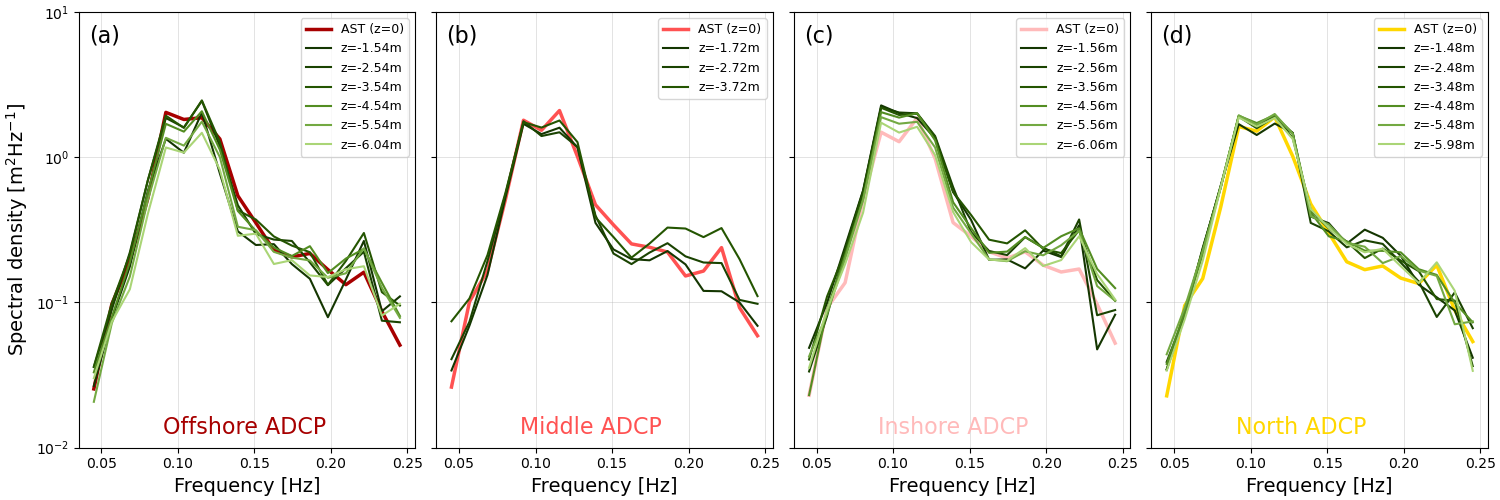

In [28]:
import matplotlib.ticker as ticker
plt.close(); plt.clf()
# Paths etc
sers = ['103088', '103094', '103110', '103206']
annot = {'SO':'Offshore ADCP', 'SM':'Middle ADCP', 'SI':'Inshore ADCP', 'SN':'North ADCP'}
abc = ['(a)', '(b)', '(c)', '(d)']
fig, axes = plt.subplots(figsize=(15,5), ncols=len(sers), constrained_layout=True, sharex=True, sharey=True)
for i,(ser,ax) in enumerate(zip(sers,axes)):
    mid = mids[ser]
    loc = sig_mids[mid]
    ann = annot[loc]
    rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
    sigdir = os.path.join(rootdir, 'Signatures')
    datadir = os.path.join(sigdir, 'Level1', ser)
    # Date(s) to analyse
    t0 = pd.Timestamp('2022-07-05')
    t1 = pd.Timestamp('2022-07-14')
    # Frequency range
    fmin = 0.045
    fmax = 0.25
    # Times + range bin(s) to plot
    t0p = pd.Timestamp('2022-07-13 04:00')
    t1p = t0p + pd.Timedelta(hours=1)
    bins = [1,2,3]
    # Define output velocity spectrum and variance dataset nc filename
    fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_{t0.strftime("%Y%m%d")}_{t1.strftime("%Y%m%d")}_max_amp_vel.nc')
    ds = xr.open_dataset(fn_nc, decode_coords='all').sel(time=t0p, freq=slice(fmin,fmax))
    # Iterate over set vertical levels below mean surface level
    rs = [] # To check that we're not plotting the same depth level more than once
    cs = ['#143601', '#1a4301', '#245501', '#538d22', '#73a942', '#aad576']
    for iz,zlev in enumerate([1.5, 2.5, 3.5, 4.5, 5.5, 6.5]):
        rz = ds.sel(range=(ds.depth-zlev), method='nearest').range.item() # Nearest range bin
        if not rz in rs:
            d = ds.depth.item() # Water depth
            # Compute linear wavenumbers for AST spectrum
            omega = 2*np.pi * ds.ASTspec.freq.values
            kl = rpws.waveno_full(omega, d=d) # Lin. waveno.s
            # Estimate velocity spectrum from AST spectrum using LWT
            factor = np.cosh(kl * rz) / np.sinh(kl * d)
            # Euu_lin = ds.ASTspec * omega**2 * factor**2
            if iz==0:
                # Plot AST spectrum only once
                ds.ASTspec.plot(ax=ax, c=clss[mid], label='AST (z=0)', lw=2.5,)
            us = ds.Uspec.sel(range=rz, method='nearest')
            vs = ds.Vspec.sel(range=rz, method='nearest')
            ws = ds.Wspec.sel(range=rz, method='nearest')
            ((us+vs)/(factor**2 * omega**2)).plot(ax=ax, x='freq', ls='-', c=cs[iz], label=f'z={-(d-rz):.2f}m')
            # LWT factor for vertical velocity
#             factor_w = np.sinh(kl * rz) / np.sinh(kl * d)
#             (ws/(factor_w**2 * omega**2)).plot(ax=ax, x='freq', ls='--', c=cs[iz], label=None)
            rs.append(rz)
#     ax.axvline(fmin, c='k', ls='--')
#     ax.axvline(fmax, c='k', ls='--')
    # ax.set_xscale('log')
    ax.set_xticks([0.05, 0.1, 0.15, 0.2, 0.25])
    ax.set_yscale('log')
    ax.set_xlabel('Frequency [Hz]', fontsize=14)
    ax.set_ylabel(None)
    ax.set_ylim([1e-2,10])
    ax.set_title(None)
    ax.grid(alpha=0.5, lw=0.5)
    ax.legend(ncols=1, loc='upper right', fontsize=9)
    ax.annotate(abc[i], xy=(0.03,0.93), xycoords='axes fraction', c='k', fontsize=16)
    ax.annotate(ann, xy=(0.25,0.03), xycoords='axes fraction', c=clss[mid], fontsize=16)
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
axes[0].set_ylabel(r'Spectral density [$\mathrm{m^2 Hz^{-1}}$]', fontsize=14)
plt.minorticks_off()
# plt.ticklabel_format(axis='x', style='plain')
# plt.show()
figdir = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray/Article_figures'
dstr = t0p.strftime('%Y%m%d_%H%M')
fn_fig = os.path.join(figdir, f'signature_hor_vel_spec_by_depth_{dstr}.pdf')
if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
    plt.close()
else:
    plt.show()


In [11]:
# Compute linear wavenumbers from AST spectrum
omega = 2*np.pi * ds.ASTspec.freq.values
kl = rpws.waveno_full(omega, d=d) # Lin. wavenumbers
# Estimate surface elevation spectrum from hor. vel. spectrum using LWT
us = ds.Uspec.sel(range=rz, method='nearest') # U spectrum at range bin rz
vs = ds.Vspec.sel(range=rz, method='nearest') # V spectrum at range bin rz
factor = np.cosh(kl * rz) / np.sinh(kl * d) # LWT factor for hor. vel.
Ezz_uv = ((us+vs) / (factor**2 * omega**2)) # Surface elevation spectrum from U+V spectra
m0_uv = Ezz_uv.integrate(coord='freq') # Surface elevation variance from Ezz_uv
# LWT factor for vertical velocity
ws = ds.Wspec.sel(range=rz, method='nearest') # W spectrum at range bin rz
factor_w = np.sinh(kl * rz) / np.sinh(kl * d) # LWT factor for vertical vel.
Ezz_w = (ws / (factor_w**2 * omega**2)) # Surface elevation spectrum from W spectrum
m0_w = Ezz_w.integrate(coord='freq') # Surface elevation variance from Ezz_w

ValueError: operands could not be broadcast together with shapes (18,) (25,) 

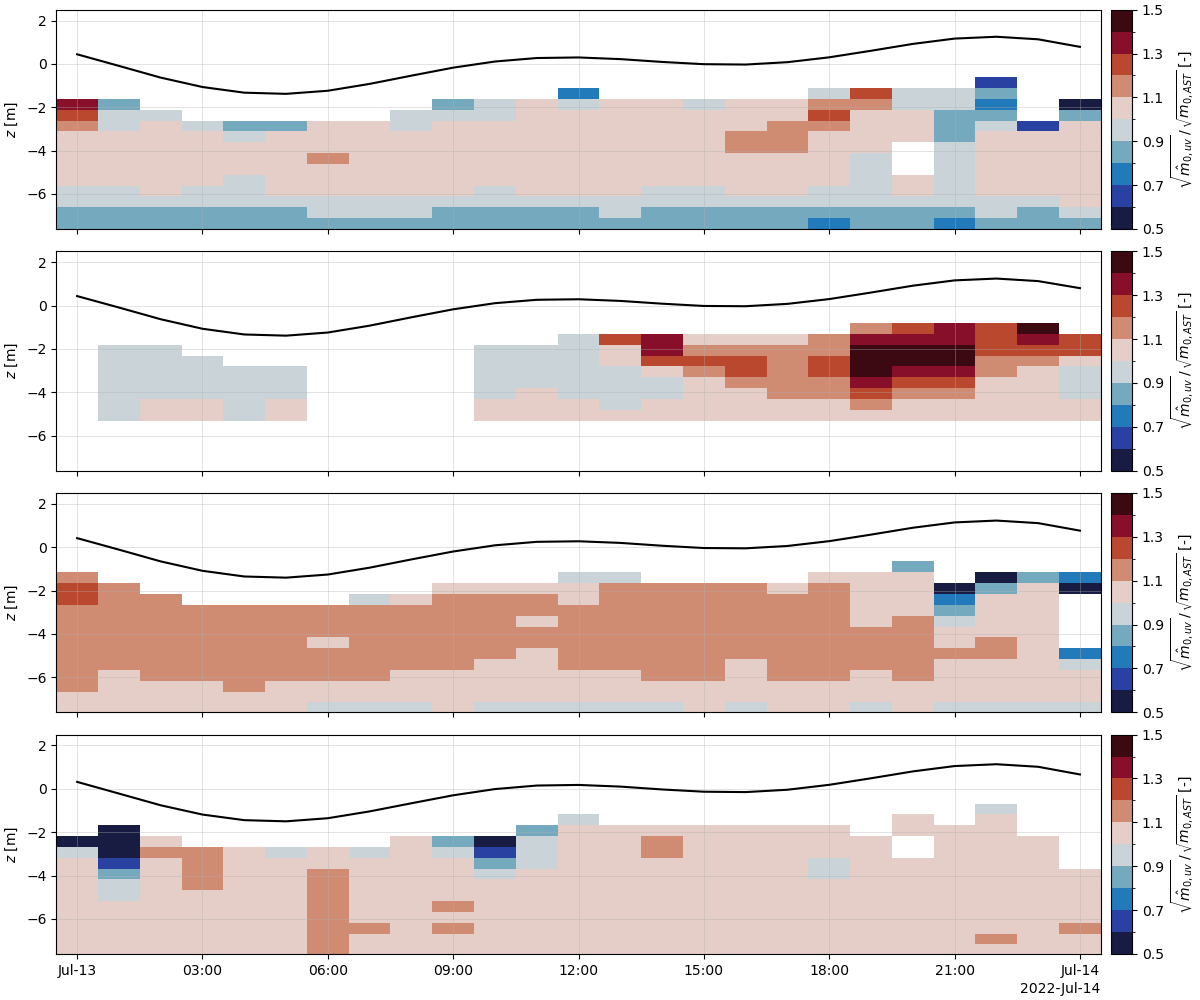

In [62]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
plt.close(); plt.clf()
# Paths etc
sers = ['103088', '103094', '103110', '103206']
annot = {'SO':'Offshore ADCP', 'SM':'Middle ADCP', 'SI':'Inshore ADCP', 'SN':'North ADCP'}
abc = ['(a)', '(b)', '(c)', '(d)']
cmap = cm.get_cmap(cmocean.cm.balance)
levels = MaxNLocator(nbins=11).tick_values(0.5, 1.5)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
fig, axes = plt.subplots(figsize=(12,10), nrows=len(sers), constrained_layout=True, sharex=True, sharey=True)
for i,(ser,ax) in enumerate(zip(sers,axes)):
    mid = mids[ser]
    loc = sig_mids[mid]
    ann = annot[loc]
    rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
    sigdir = os.path.join(rootdir, 'Signatures')
    datadir = os.path.join(sigdir, 'Level1', ser)
    # Date(s) to analyse
    t0 = pd.Timestamp('2022-07-05')
    t1 = pd.Timestamp('2022-07-14')
    # Frequency range
    # fmin = 0.045
    # fmax = 0.25 # -> nfreqs=18
    fmin = 0.08
    fmax = 0.15 # -> nfreqs=6
    # Times + range bin(s) to plot
    t0p = pd.Timestamp('2022-07-13 00:00')
    t1p = t0p + pd.Timedelta(days=1)
    bins = [1,2,3]
    # Define output velocity spectrum and variance dataset nc filename
    fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_{t0.strftime("%Y%m%d")}_{t1.strftime("%Y%m%d")}_max_amp_vel.nc')
    ds = xr.open_dataset(fn_nc, decode_coords='all')
    d_avg = np.atleast_1d(ds.depth.mean().item()) # Experiment mean depth
    ds = ds.sel(time=slice(t0p,t1p), freq=slice(fmin,fmax)) # Select only requested period and frequency range
    # Estimate ratios of measured vs. LWT estimates of ADCP velocities
    d = ds.depth.values # Hourly water depths
    # Make z axis with 0 at surface for plotting
    ds['z'] = (['time', 'range'], np.broadcast_to(ds.range.values[np.newaxis, :], (25,28))-d_avg[:,np.newaxis])
    # Compute linear wavenumbers for AST spectrum
    omega = 2*np.pi * ds.ASTspec.freq.values
    omega_3d = np.broadcast_to(omega[np.newaxis, :, np.newaxis], (25,6,28))
    ds['omega'] = (['time', 'freq', 'range'], omega_3d)
    kls = [rpws.waveno_full(omega, d=di) for di in ds.depth.values] # Lin. waveno.s
    ds['kl'] = (['freq','time'], np.array(kls).T)
    # Estimate velocity spectrum from AST spectrum using LWT
    factor = [np.cosh(ds.kl.values * r) / np.sinh(ds.kl.values * d) for r in ds.range.values]
    ds['factor'] = (['time','freq','range'], np.array(factor).T)
    # Estimate surface elevation variance from uvar+vvar using LWT
    zvar_from_uv = ((ds.Uspec+ds.Vspec)/(ds.factor**2 * ds.omega**2)).integrate(coord='freq')
    # Estimate AST variance at same frequency band
    astvar = ds.ASTspec.integrate(coord='freq')
    # Plot profiles of measured / LWT
    ratio = (np.sqrt(zvar_from_uv) / np.sqrt(astvar))
#     ratio.plot.pcolormesh(ax=ax, x='time', y='z', cmap=cmocean.cm.balance, vmin=0.5, vmax=1.5, levels=11, 
#                           cbar_kwargs={'pad':0.005, 'label':r'$\sqrt{\mathrm{var}(U) \, / \, \mathrm{var}(U_\mathrm{LWT})}$'},)
    im = ax.pcolormesh(np.broadcast_to(ds.time.values[:,np.newaxis], (25,28)), ds.z.values, ratio, cmap=cmap, norm=norm,)
    (ds.depth-d_avg.item()).plot(ax=ax, c='k', label=f'Water level at {loc}')
    # Colorbar on right
    cax = ax.inset_axes([1.01, 0.00, 0.02, 1.0], transform=ax.transAxes)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel(r'$\sqrt{\hat{m}_{0,uv}} \, / \, \sqrt{m_{0,AST}}$ [-]')
    # Limits, labels, etc.
    ax.set_ylim([None,2.5])
    ax.set_xlabel(None)
    ax.set_ylabel(r'$z$ [m]')
    ax.grid(alpha=0.5, lw=0.5)

# plt.ticklabel_format(axis='x', style='plain')
# plt.show()
figdir = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray/Article_figures'
dstr = t0p.strftime('%Y%m%d_%H%M')
fn_fig = os.path.join(figdir, f'signature_hor_vel_vs_lwt_profiles_{dstr}.pdf')
if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
# plt.close()
plt.show()


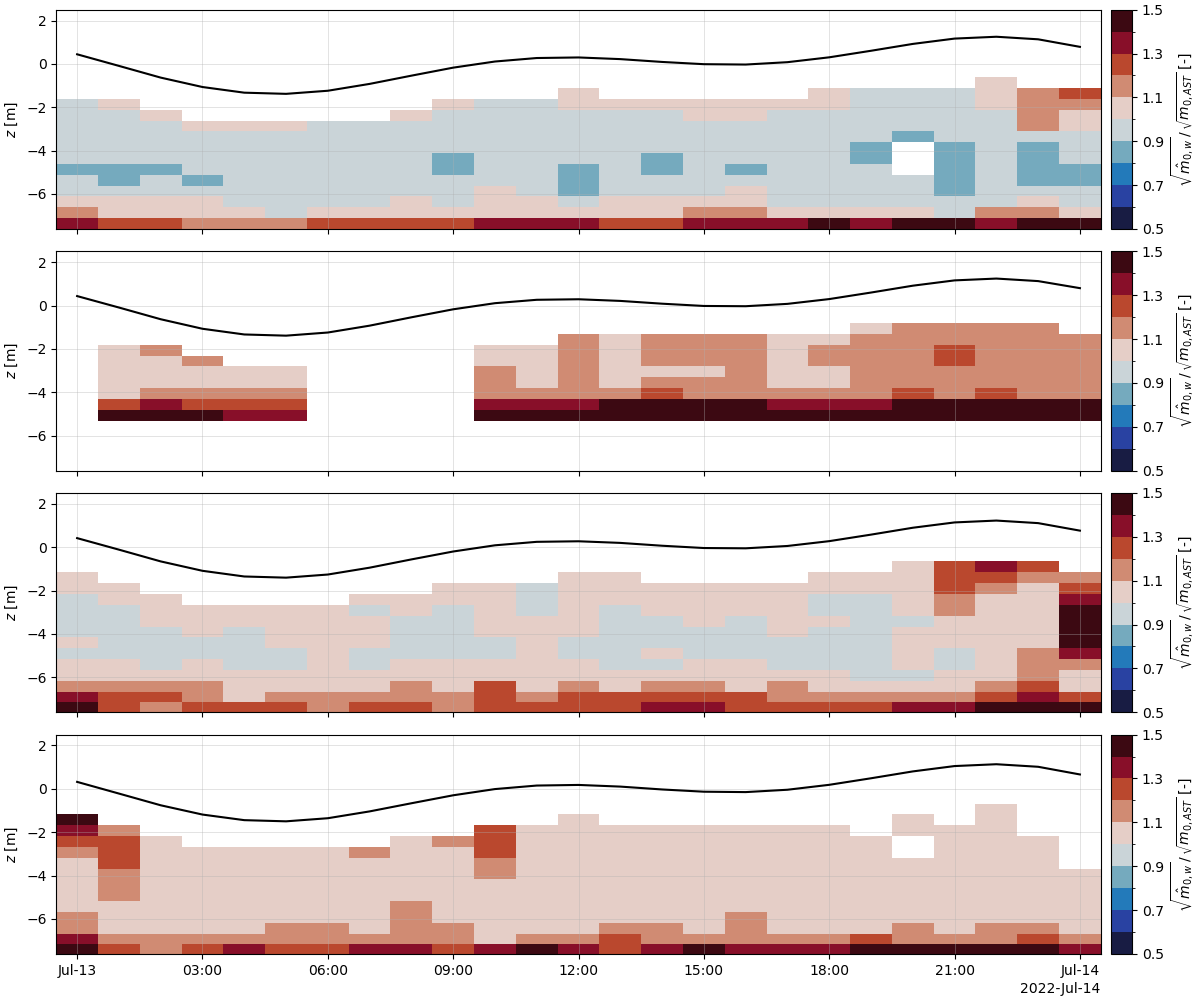

In [65]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
plt.close(); plt.clf()
# Paths etc
sers = ['103088', '103094', '103110', '103206']
annot = {'SO':'Offshore ADCP', 'SM':'Middle ADCP', 'SI':'Inshore ADCP', 'SN':'North ADCP'}
abc = ['(a)', '(b)', '(c)', '(d)']
# cmap = cm.get_cmap(cmocean.cm.ice)
# levels = MaxNLocator(nbins=11).tick_values(0.0, 2.0)
cmap = cm.get_cmap(cmocean.cm.balance)
levels = MaxNLocator(nbins=11).tick_values(0.5, 1.5)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
fig, axes = plt.subplots(figsize=(12,10), nrows=len(sers), constrained_layout=True, sharex=True, sharey=True)
for i,(ser,ax) in enumerate(zip(sers,axes)):
    mid = mids[ser]
    loc = sig_mids[mid]
    ann = annot[loc]
    rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
    sigdir = os.path.join(rootdir, 'Signatures')
    datadir = os.path.join(sigdir, 'Level1', ser)
    # Date(s) to analyse
    t0 = pd.Timestamp('2022-07-05')
    t1 = pd.Timestamp('2022-07-14')
    # Frequency range
    # fmin = 0.045
    # fmax = 0.25
    fmin = 0.08
    fmax = 0.15
    # Times + range bin(s) to plot
    t0p = pd.Timestamp('2022-07-13 00:00')
    t1p = t0p + pd.Timedelta(days=1)
    bins = [1,2,3]
    # Define output velocity spectrum and variance dataset nc filename
    fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_{t0.strftime("%Y%m%d")}_{t1.strftime("%Y%m%d")}_max_amp_vel.nc')
    ds = xr.open_dataset(fn_nc, decode_coords='all')
    d_avg = np.atleast_1d(ds.depth.mean().item()) # Experiment mean depth
    ds = ds.sel(time=slice(t0p,t1p), freq=slice(fmin,fmax)) # Select only requested period and frequency range
    # Estimate ratios of measured vs. LWT estimates of ADCP velocities
    d = ds.depth.values # Hourly water depths
    # Make z axis with 0 at surface for plotting
    ds['z'] = (['time', 'range'], np.broadcast_to(ds.range.values[np.newaxis, :], (25,28))-d_avg[:,np.newaxis])
    # Compute linear wavenumbers for AST spectrum
    omega = 2*np.pi * ds.ASTspec.freq.values
    omega_3d = np.broadcast_to(omega[np.newaxis, :, np.newaxis], (25,6,28))
    ds['omega'] = (['time', 'freq', 'range'], omega_3d)
    kls = [rpws.waveno_full(omega, d=di) for di in ds.depth.values] # Lin. waveno.s
    ds['kl'] = (['freq','time'], np.array(kls).T)
    # Estimate velocity spectrum from AST spectrum using LWT
    factor = [np.sinh(ds.kl.values * r) / np.sinh(ds.kl.values * d) for r in ds.range.values]
    ds['factor'] = (['time','freq','range'], np.array(factor).T)
    # Estimate surface elevation variance from uvar+vvar using LWT
    zvar_from_w = (ds.Wspec/(ds.factor**2 * ds.omega**2)).integrate(coord='freq')
    # Estimate AST variance at same frequency band
    astvar = ds.ASTspec.integrate(coord='freq')
    # Plot profiles of measured / LWT
    ratio = (np.sqrt(zvar_from_w) / np.sqrt(astvar))
#     ratio.plot.pcolormesh(ax=ax, x='time', y='z', cmap=cmocean.cm.balance, vmin=0.5, vmax=1.5, levels=11, 
#                           cbar_kwargs={'pad':0.005, 'label':r'$\sqrt{\mathrm{var}(U) \, / \, \mathrm{var}(U_\mathrm{LWT})}$'},)
    im = ax.pcolormesh(np.broadcast_to(ds.time.values[:,np.newaxis], (25,28)), ds.z.values, ratio, cmap=cmap, norm=norm,)
    (ds.depth-d_avg.item()).plot(ax=ax, c='k', label=f'Water level at {loc}')
    # Colorbar on right
    cax = ax.inset_axes([1.01, 0.00, 0.02, 1.0], transform=ax.transAxes)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel(r'$\sqrt{\hat{m}_{0,w}} \, / \, \sqrt{m_{0,AST}}$ [-]')
    # Limits, labels, etc.
    ax.set_ylim([None,2.5])
    ax.set_xlabel(None)
    ax.set_ylabel(r'$z$ [m]')
    ax.grid(alpha=0.5, lw=0.5)

# plt.ticklabel_format(axis='x', style='plain')
# plt.show()
figdir = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray/Article_figures'
dstr = t0.strftime('%Y%m%d_%H%M')
fn_fig = os.path.join(figdir, f'signature_vert_vel_vs_lwt_profiles_frange_008-015_{dstr}.pdf')
# plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
# plt.close()
plt.show()

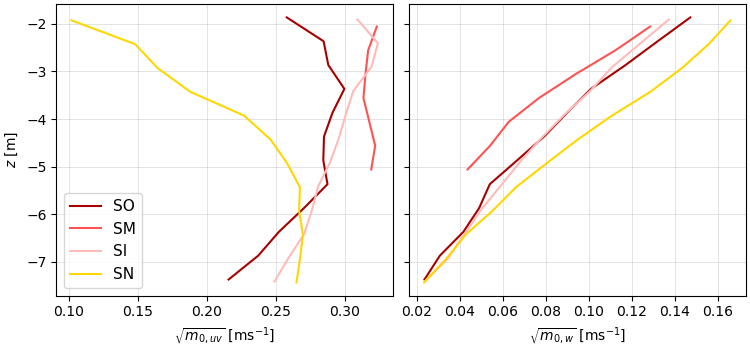

In [103]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
plt.close(); plt.clf()
# Paths etc
sers = ['103088', '103094', '103110', '103206']
annot = {'SO':'Offshore ADCP', 'SM':'Middle ADCP', 'SI':'Inshore ADCP', 'SN':'North ADCP'}
abc = ['(a)', '(b)', '(c)', '(d)']
# cmap = cm.get_cmap(cmocean.cm.ice)
# levels = MaxNLocator(nbins=11).tick_values(0.0, 2.0)
cmap = cm.get_cmap(cmocean.cm.balance)
levels = MaxNLocator(nbins=11).tick_values(0.5, 1.5)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
fig, axes = plt.subplots(figsize=(7.5,3.5), ncols=2, sharey=True, constrained_layout=True)
for i,ser in enumerate(sers):
    mid = mids[ser]
    loc = sig_mids[mid]
    ann = annot[loc]
    rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
    sigdir = os.path.join(rootdir, 'Signatures')
    datadir = os.path.join(sigdir, 'Level1', ser)
    # Date(s) to analyse
    t0 = pd.Timestamp('2022-07-05')
    t1 = pd.Timestamp('2022-07-14')
    # Frequency range
    # fmin = 0.045
    # fmax = 0.25
    fmin = 0.08
    fmax = 0.15
    # Times + range bin(s) to plot
    t0p = pd.Timestamp('2022-07-13 00:00')
    t1p = t0p + pd.Timedelta(days=1)
    t0pp = pd.Timestamp('2022-07-13 01:00')
    t1pp = t0pp + pd.Timedelta(hours=5)
    bins = [1,2,3]
    # Define output velocity spectrum and variance dataset nc filename
    fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_{t0.strftime("%Y%m%d")}_{t1.strftime("%Y%m%d")}_max_amp_vel.nc')
    ds = xr.open_dataset(fn_nc, decode_coords='all')
    d_avg = np.atleast_1d(ds.depth.mean().item()) # Experiment mean depth
    ds = ds.sel(time=slice(t0p,t1p), freq=slice(fmin,fmax)) # Select only requested period and frequency range
    # Estimate ratios of measured vs. LWT estimates of ADCP velocities
    d = ds.depth.values # Hourly water depths
    # Make z axis with 0 at surface for plotting
    ds['z'] = (['time', 'range'], np.broadcast_to(ds.range.values[np.newaxis, :], (25,28))-d_avg[:,np.newaxis])
    # Compute linear wavenumbers for AST spectrum
    omega = 2*np.pi * ds.ASTspec.freq.values
    omega_3d = np.broadcast_to(omega[np.newaxis, :, np.newaxis], (25,6,28))
    ds['omega'] = (['time', 'freq', 'range'], omega_3d)
    kls = [rpws.waveno_full(omega, d=di) for di in ds.depth.values] # Lin. waveno.s
    ds['kl'] = (['freq','time'], np.array(kls).T)
    # Estimate velocity spectrum from AST spectrum using LWT
    factor = [np.sinh(ds.kl.values * r) / np.sinh(ds.kl.values * d) for r in ds.range.values]
    ds['factor'] = (['time','freq','range'], np.array(factor).T)
    # Estimate surface elevation variance from uvar+vvar using LWT
    zvar_from_w = (ds.Wspec/(ds.factor**2 * ds.omega**2)).integrate(coord='freq')
    # Estimate AST variance at same frequency band
    astvar = ds.ASTspec.integrate(coord='freq')
    # LWT velocities from AST-variance at bin depths
    wvar_from_ast = (ds.ASTspec * ds.factor**2 * ds.omega**2).integrate(coord='freq')
    # Plot profiles of measured / LWT
    ratio = (np.sqrt(zvar_from_w) / np.sqrt(astvar))
#     ratio.plot.pcolormesh(ax=ax, x='time', y='z', cmap=cmocean.cm.balance, vmin=0.5, vmax=1.5, levels=11, 
#                           cbar_kwargs={'pad':0.005, 'label':r'$\sqrt{\mathrm{var}(U) \, / \, \mathrm{var}(U_\mathrm{LWT})}$'},)
    # im = ax.pcolormesh(np.broadcast_to(ds.time.values[:,np.newaxis], (25,28)), ds.z.values, ratio, cmap=cmap, norm=norm,)
    # Horizontal velocity profiles
    axes[0].plot(np.sqrt((ds.Uspec.sel(time=t0pp) + ds.Vspec.sel(time=t0pp)).integrate(coord='freq')), ds.z.sel(time=t0pp), c=clss[mid], ls='-', label=loc)
    mhspec = (ds.Uspec + ds.Vspec).integrate(coord='freq').sel(time=slice(t0pp,t1pp)).mean('time')
    shspec = (ds.Uspec + ds.Vspec).integrate(coord='freq').sel(time=slice(t0pp,t1pp)).std('time')
#     axes[0].plot(mhspec, ds.z.sel(time=t0pp), c=clss[mid], ls='-', label=loc)
#     axes[0].plot(mhspec+shspec, ds.z.sel(time=t0pp), c=clss[mid], ls='--', lw=0.5)
#     axes[0].plot(mhspec-shspec, ds.z.sel(time=t0pp), c=clss[mid], ls='--', lw=0.5)
    # Vertical velocity profiles
    axes[1].plot(np.sqrt(ds.Wspec.sel(time=t0pp).integrate(coord='freq')), ds.z.sel(time=t0pp), c=clss[mid], ls='-')
    mvspec = ds.Wspec.integrate(coord='freq').sel(time=slice(t0pp,t1pp)).mean('time')
    svspec = ds.Wspec.integrate(coord='freq').sel(time=slice(t0pp,t1pp)).std('time')
#     axes[1].plot(mvspec, ds.z.sel(time=t0pp), c=clss[mid], ls='-')
#     axes[1].plot(wvar_from_ast.sel(time=slice(t0pp,t1pp)).mean('time'), ds.z.sel(time=t0pp), c=clss[mid], ls='--')
#     axes[1].plot(mvspec+svspec, ds.z.sel(time=t0pp), c=clss[mid], ls='--', lw=0.5)
#     axes[1].plot(mvspec-svspec, ds.z.sel(time=t0pp), c=clss[mid], ls='--', lw=0.5)
    # Limits, labels, etc.
    axes[0].set_xlabel(r'$\sqrt{m_{0,uv}} \, \, [\mathrm{ms^{-1}}]$')
    axes[1].set_xlabel(r'$\sqrt{m_{0,w}} \, \, [\mathrm{ms^{-1}}]$')
    axes[0].set_ylabel(r'$z$ [m]')
#     axes[0].set_xlim([0,0.16])
#     axes[1].set_xlim([0,0.026])
    axes[0].legend(fontsize=11)
    for ax in axes:
        ax.grid(alpha=0.5, lw=0.5)

figdir = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray/Article_figures'
dstr = t0pp.strftime('%Y%m%d_%H%M')
fn_fig = os.path.join(figdir, f'signature_hor_vert_vel_profiles_frange_008-015_{dstr}.pdf')
if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
# plt.close()
else:
    plt.show()
# plt.ticklabel_format(axis='x', style='plain')
# plt.show()

In [71]:
ds

<xarray.Dataset> Size: 194kB
Dimensions:  (freq: 6, range: 28, time: 25)
Coordinates:
  * freq     (freq) float64 48B 0.08038 0.09214 0.1039 0.1157 0.1274 0.1392
  * range    (range) float64 224B 0.9188 1.419 1.919 2.419 ... 13.42 13.92 14.42
  * time     (time) datetime64[ns] 200B 2022-07-13 ... 2022-07-14
Data variables: (12/17)
    Uspec    (time, freq, range) float64 34kB ...
    Vspec    (time, freq, range) float64 34kB ...
    Wspec    (time, freq, range) float64 34kB ...
    ASTspec  (freq, time) float64 1kB 1.099 0.9712 0.5617 ... 0.5991 0.5884 0.76
    Uvar     (time, range) float64 6kB ...
    Vvar     (time, range) float64 6kB ...
    ...       ...
    fp       (time) float64 200B ...
    kp       (time) float64 200B ...
    z        (time, range) float64 6kB -7.429 -6.929 -6.429 ... 5.571 6.071
    omega    (time, freq, range) float64 34kB 0.505 0.505 ... 0.8746 0.8746
    kl       (freq, time) float64 1kB 0.05691 0.05862 0.06053 ... 0.1039 0.1054
    factor   (time, freq, range) float64 34kB 0.1019 0.1574 ... 1.868 1.98

Plot individual hourly velocity profiles for given serial numbers.

In [ ]:
plt.clf()
plt.close()

sers = ['103088', '103094', '103206', '103110']
dsd = []
for ser in sers:
    fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_20220705_20220714_max_amp_vel.nc')
    dsd.append(xr.open_dataset(fn_nc, decode_coords='all'))

# datetimes = pd.date_range('2022-07-06', '2022-07-15', freq='1h')
datetimes = pd.date_range('2022-07-13', '2022-07-15', freq='1h')
for t0p in tqdm(datetimes):
    # Time to plot
    # t0p = pd.Timestamp('2022-07-13 05:00')
    fig, axes = plt.subplots(figsize=(8,6), ncols=2, sharey=True, sharex=True, constrained_layout=True)
    for ds,ser in zip(dsd,sers):
        mid = mids[ser]
        loc = sig_mids[mid]
        # Depth offset vs. SN depth
        depth_loc = ds.depth.sel(time=t0p).item()
        depth_north = dsd[-1].depth.sel(time=t0p).item()
        d_offset = depth_north - depth_loc
        dp = ((ds.range.values + d_offset) - depth_north)# / depth_north
        # (ds.Uvar + ds.Vvar).sel(time=t0p).plot(ax=axes[0], y='range', label=ser)
        axes[0].plot(np.sqrt((ds.Uvar + ds.Vvar)).sel(time=t0p), dp, label=loc, c=clss[mid])
        # ds.Wvar.sel(time=t0p).plot(ax=axes[1], y='range', label=ser)
        axes[1].plot(np.sqrt(ds.Wvar).sel(time=t0p), dp, label=loc, c=clss[mid])
        # LWT estimate
        m0 = rpws.spec_moment(ds.ASTspec.sel(time=t0p).values, ds.freq.values, 0)
        m1 = rpws.spec_moment(ds.ASTspec.sel(time=t0p).values, ds.freq.values, 1)
        fm = m1 / m0 # Mean wave freq. from AST spectrum
        k = rpws.waveno_full(2*np.pi*fm, depth_loc)
        u_lwt = np.cosh(k*(ds.range+0.35)) / np.sinh(k*depth_loc) * np.sqrt(np.mean(ds.ASTvar.sel(time=t0p)))*2*np.pi*fm
        axes[0].plot(u_lwt, dp, label=f'{loc} (LWT)', c=clss[mid], ls='--')
        w_lwt = np.sinh(k*(ds.range+0.35)) / np.sinh(k*depth_loc) * np.sqrt(np.mean(ds.ASTvar.sel(time=t0p)))*2*np.pi*fm
        axes[1].plot(w_lwt, dp, label=f'{loc} (LWT)', c=clss[mid], ls='--')
    axes[0].set_xlabel(r'$\sqrt{(\mathrm{Uvar + Vvar)}}$ [m/s]')
    axes[1].set_xlabel(r'$\sqrt{\mathrm{Wvar}}$ [m/s]')
    axes[0].set_ylabel('Depth below surface [m]')
    axes[1].set_ylabel(None)

    # Shared axis params
    for ax in axes:
        ax.legend()
        ax.set_title(None)
        ax.set_xlim([0,0.6])
        ax.set_ylim([None,0])
        ax.grid(alpha=0.5, lw=0.5)

    # Shared title with date + time
    plt.suptitle(str(t0p))
    # Save figure
    figdir = os.path.join(sigdir, 'vel_vs_lwt')
    if not os.path.isdir(figdir):
        os.mkdir(figdir)
    datestr = pd.Timestamp(t0p).strftime('%Y%m%d_%H%M')
    fn_fig = os.path.join(figdir, f'orb_vel_profiles_vs_lwt_{datestr}_v3.png')
    if not os.path.isfile(fn_fig):
        print(f'Saving figure {fn_fig} ...')
        plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
    # plt.show()
    plt.close()

Plot profiles of measured/LWT estimates of std(U) and std(W) for given serial number.

In [ ]:
plt.clf()
plt.close()

# Date to plot
t0p = '2022-07-13'
# Define serial numbers to plot and read netcdf file
sers = ['103088', '103094', '103110', '103206']

# Dates to plot
dates = pd.date_range('2022-07-05', '2022-07-14', freq='1d')
for date in tqdm(dates):
    # t0p = '2022-07-13'
    t0p = date.strftime('%Y-%m-%d')
    # Initialize figure
    fig, axes = plt.subplots(figsize=(10,12), nrows=4, sharex=True, sharey=True, constrained_layout=True)
    # ITerate over serial numbers
    for ser,ax in zip(sers,axes):
        # Read correct netcdf file
        mid = mids[ser]
        loc = sig_mids[mid]
        fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_20220705_20220714_max_amp_vel.nc')
        ds = xr.open_dataset(fn_nc, decode_coords='all')

        # Plot measured U_std vs LWT estimate
        # ax.plot(np.sqrt((ds.Uvar + ds.Vvar)).sel(time=t0p), ds.range)
        # Measured std(U)
        u_meas = np.sqrt((ds.Uvar + ds.Vvar)).sel(time=t0p).copy()
        # LWT estimate
        k = ds.km.sel(time=t0p).copy()
        f = ds.fm.sel(time=t0p).copy()
        z = ds.range.copy()
        h = ds.depth.sel(time=t0p).copy()
        ASTvar = ds.ASTvar.sel(time=t0p).copy()
        u_lwt = np.cosh(k*z) / np.sinh(k*h) * np.sqrt(np.mean(ASTvar))*2*np.pi*f
        # Plot profiles of ratio of w_meas/w_lwt
        u_ratio = (u_meas/u_lwt)
        # Set min/max range for colormap
        vmax = abs(max(u_ratio.max().item(), u_ratio.min().item()))
        dv = vmax - 1
        # Plot
        #u_ratio.plot.pcolormesh(ax=ax, x='time', y='range', cmap=cmocean.cm.balance, vmin=1-dv, vmax=1+dv, levels=11)
        u_ratio.plot.pcolormesh(ax=ax, x='time', y='range', cmap=cmocean.cm.balance, 
                                vmin=0.5, vmax=1.5, levels=11, cbar_kwargs={'pad':0.005, 
                                                                            'label':r'$\sqrt{\mathrm{var}(U) \, / \, \mathrm{var}(U_\mathrm{LWT})}$'},
                                )
        ds.depth.sel(time=t0p).plot(ax=ax, c='k', label=f'Water level at {loc}')

        # Axis limits, labels, etc
        ax.set_ylim([0,12])
        ax.set_xlabel(None)
        ax.set_ylabel(f'Range from bottom [m]')
        ax.legend(loc='upper right')

    axes[0].set_title(f'Horizontal velocity measured/LWT on {str(t0p)}')
    # Save or show
    figdir = os.path.join(sigdir, 'vel_vs_lwt')
    if not os.path.isdir(figdir):
        os.mkdir(figdir)
    datestr = pd.Timestamp(t0p).strftime('%Y%m%d')
    fn_fig = os.path.join(figdir, f'u_meas_vs_lwt_profiles_{datestr}_v2.png')
    # plt.show()
    if not os.path.isfile(fn_fig):
        print(f'Saving figure {fn_fig} ...')
        plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
    plt.close()


Same as previous plot, but for vertical velocity profiles.

  0%|          | 0/10 [00:00<?, ?it/s]

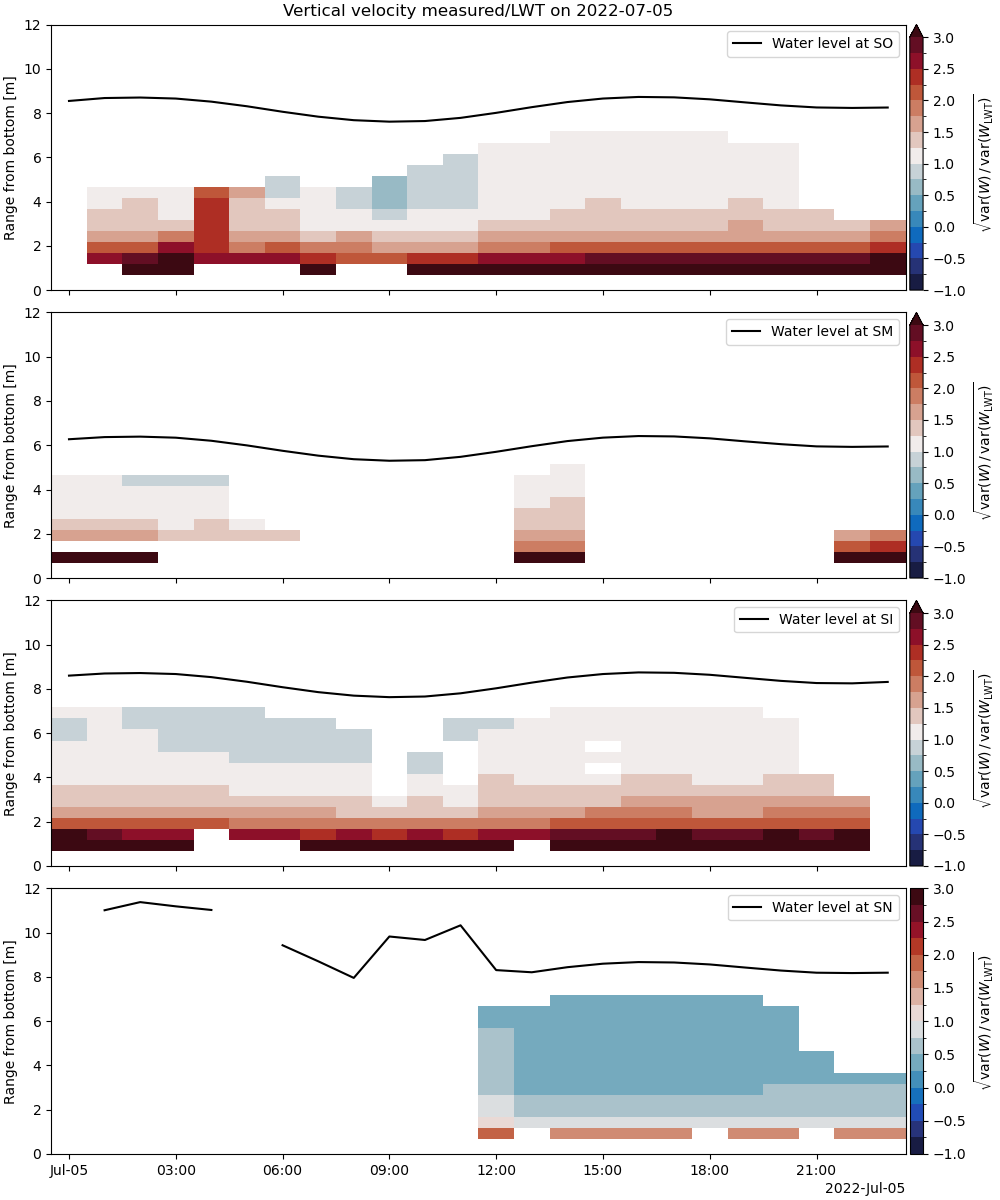

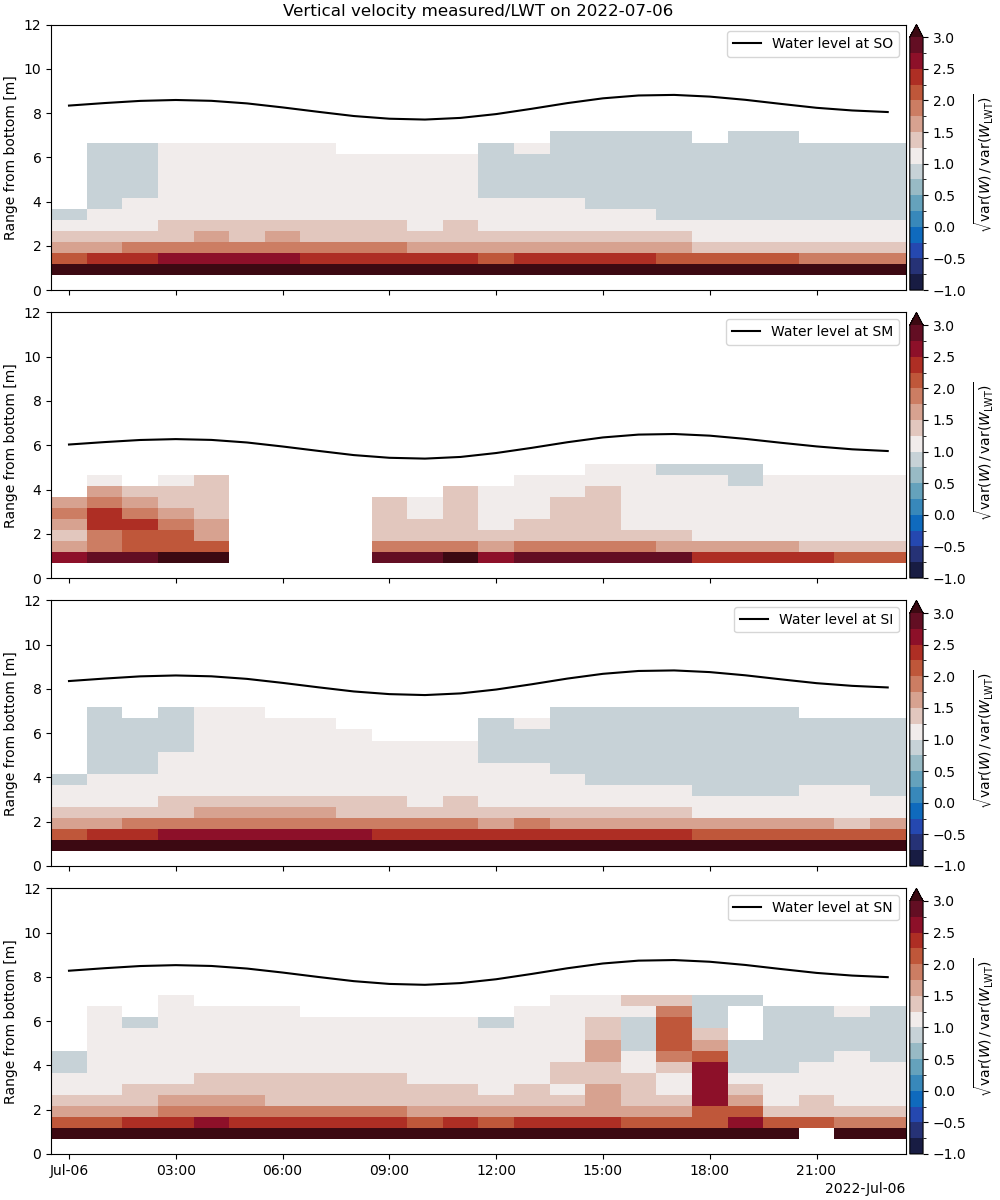

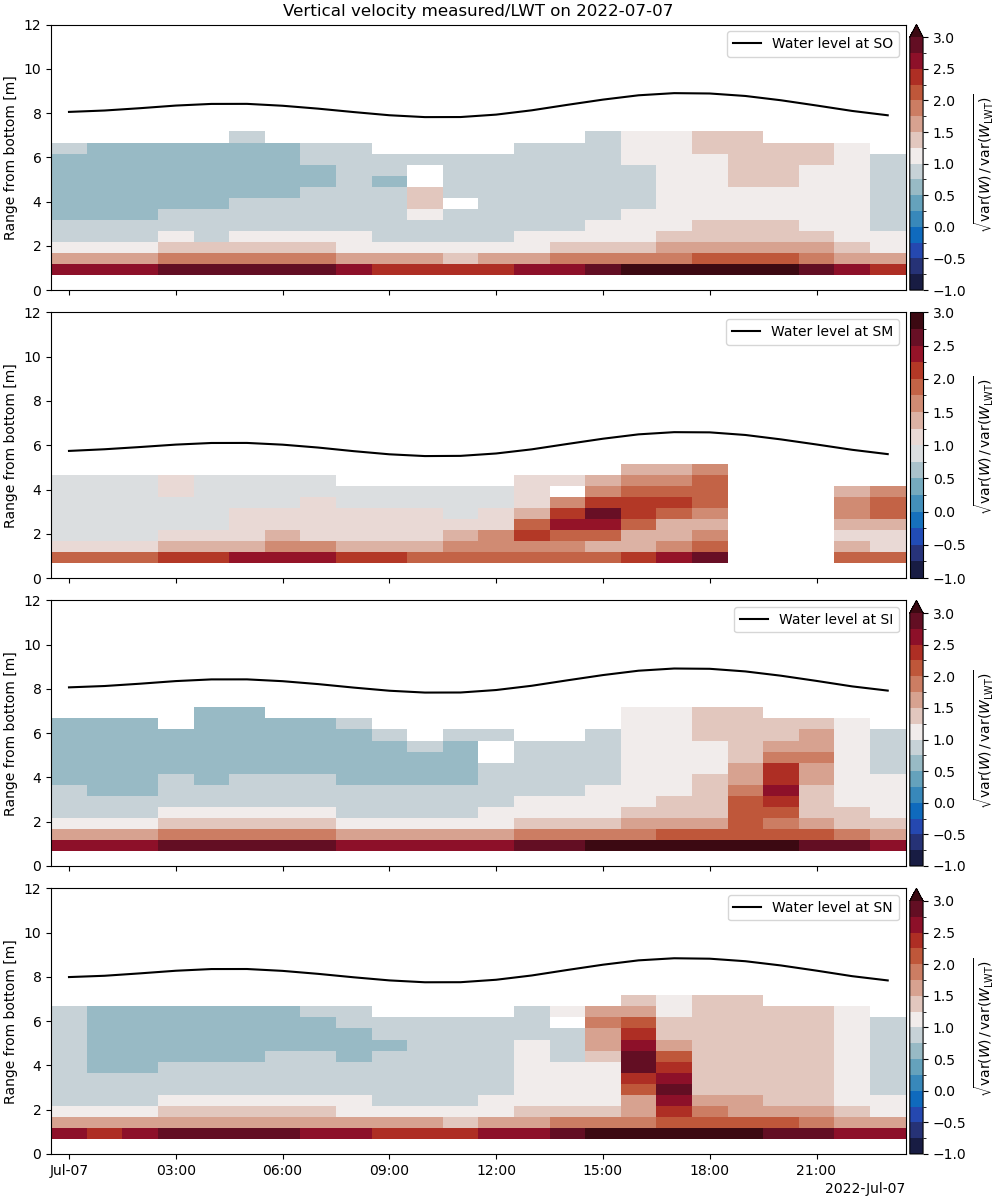

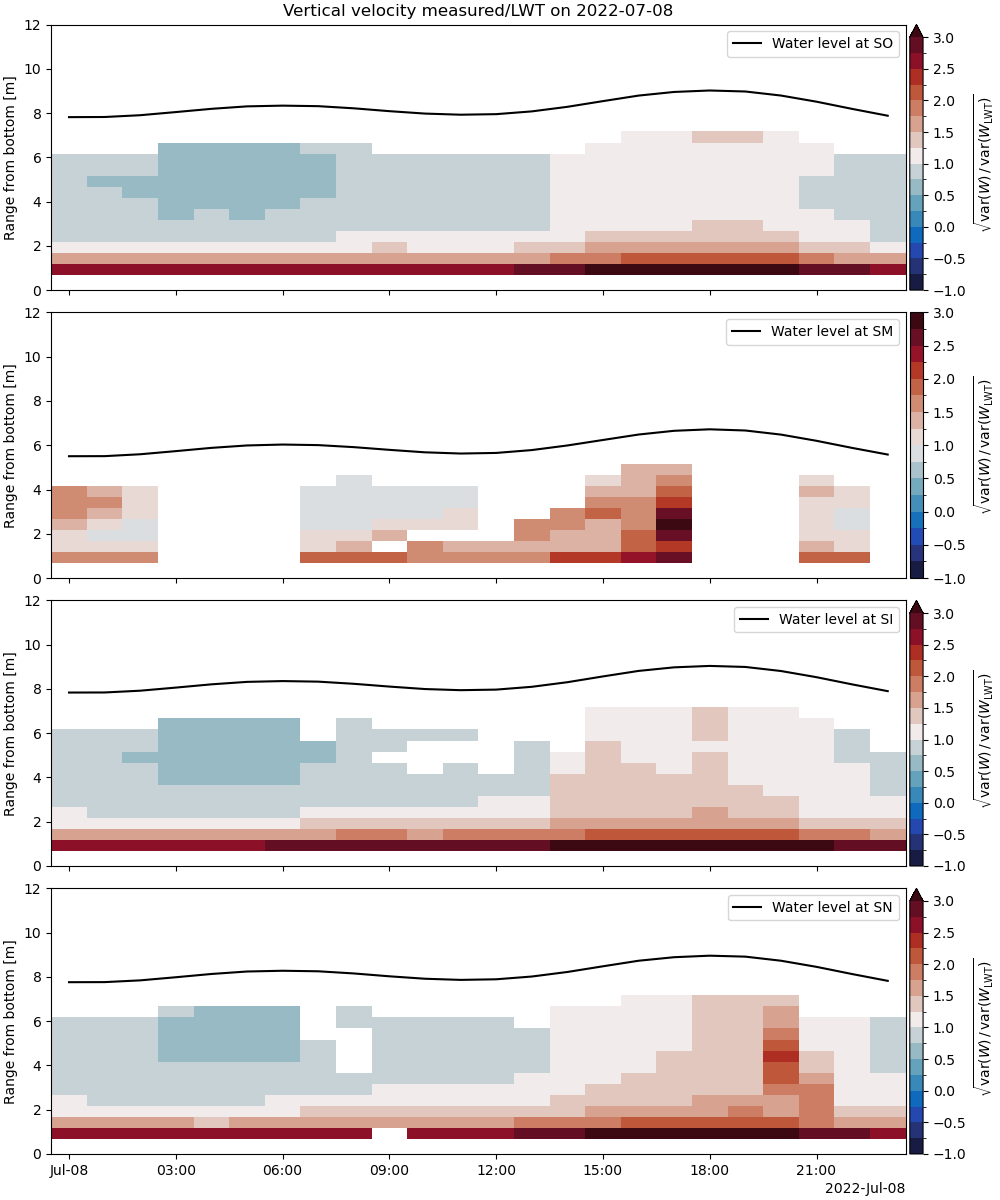

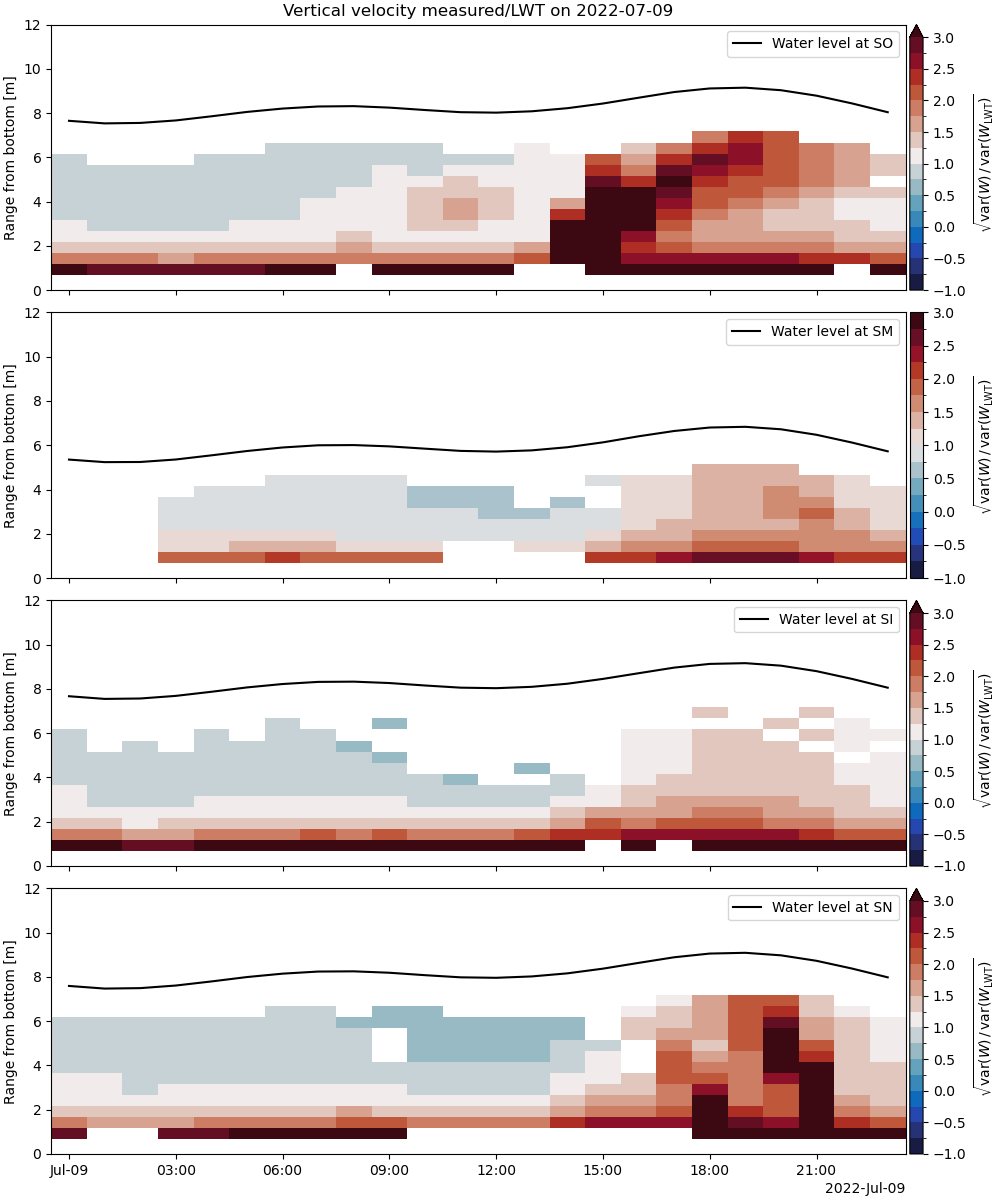

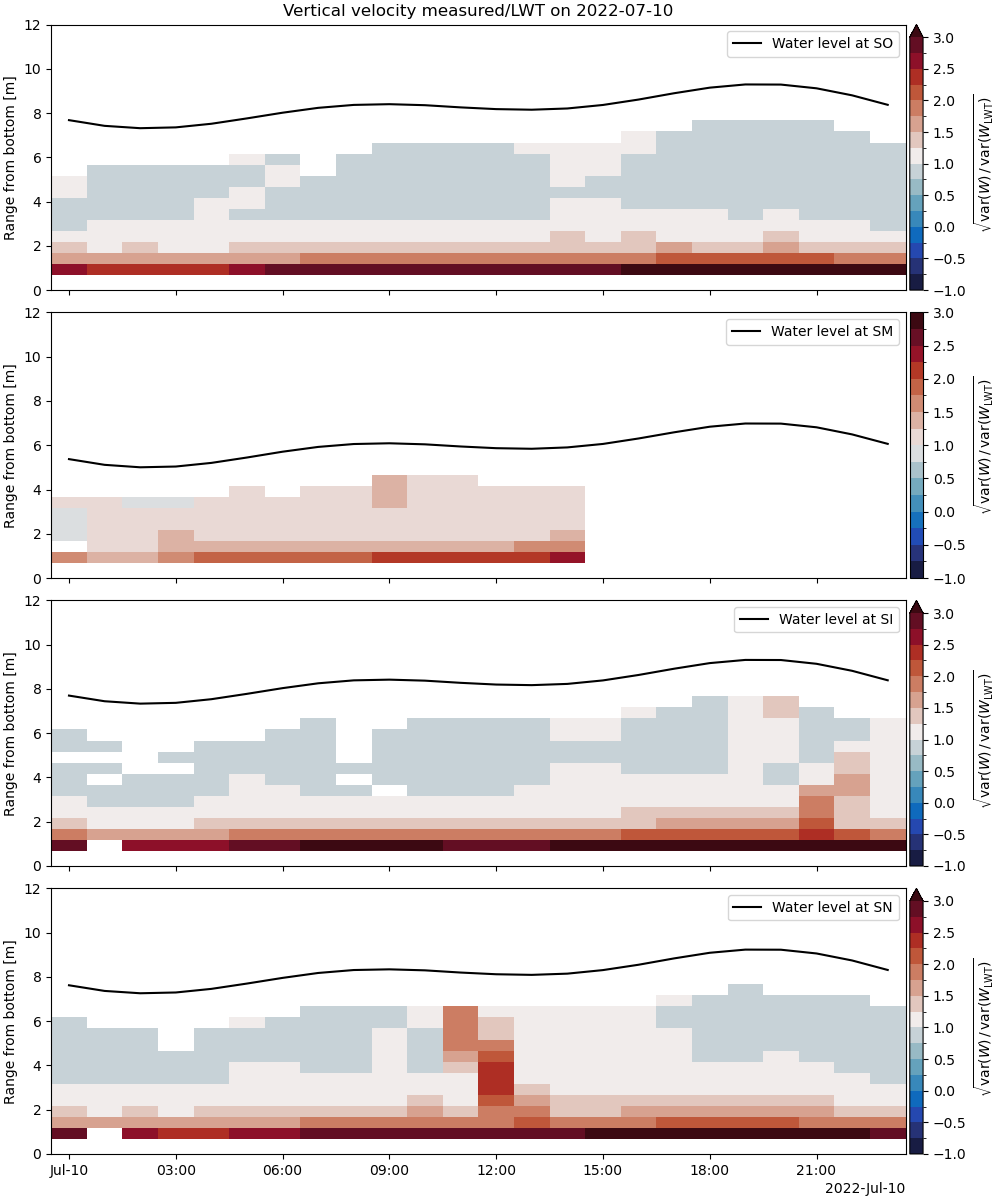

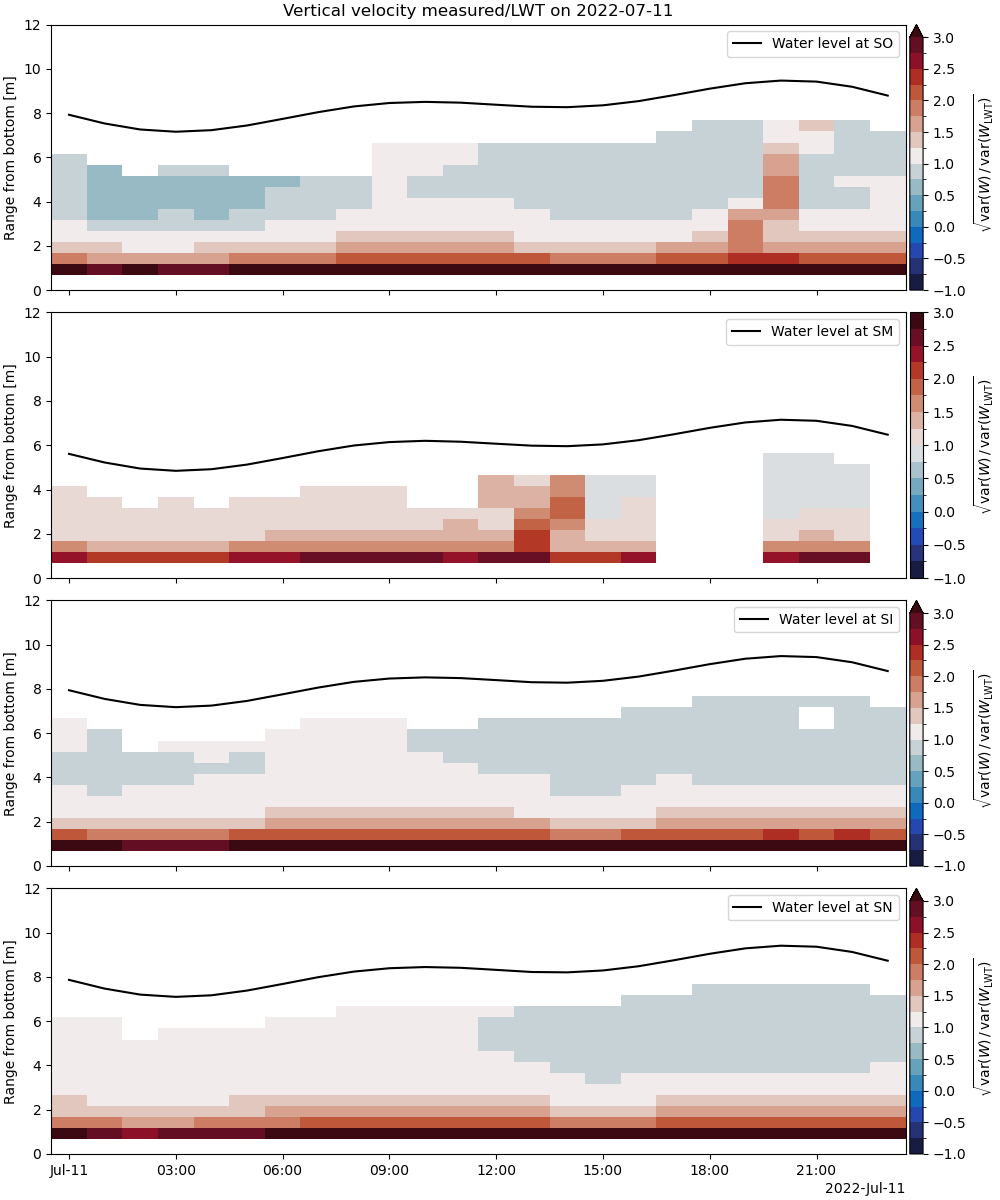

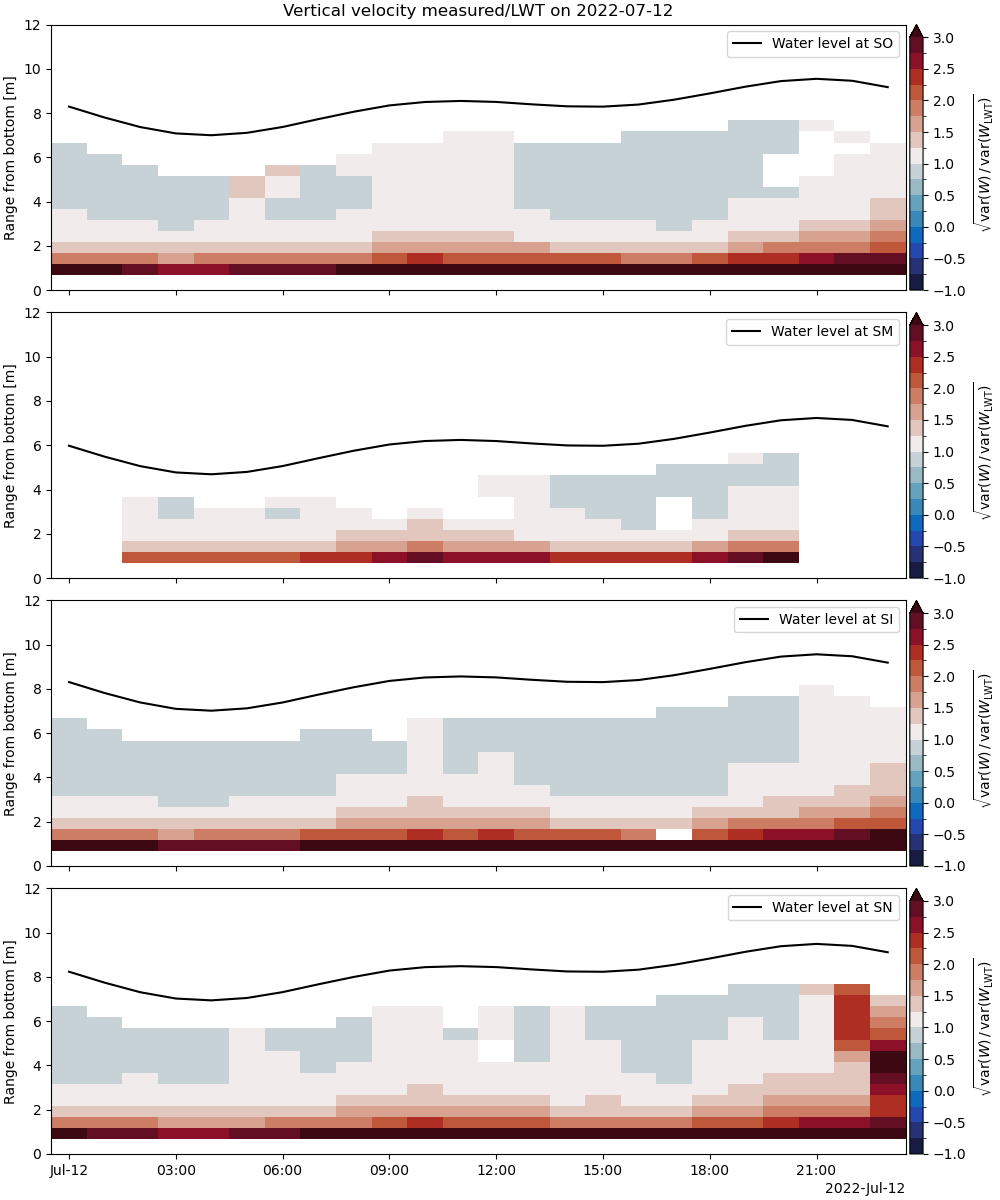

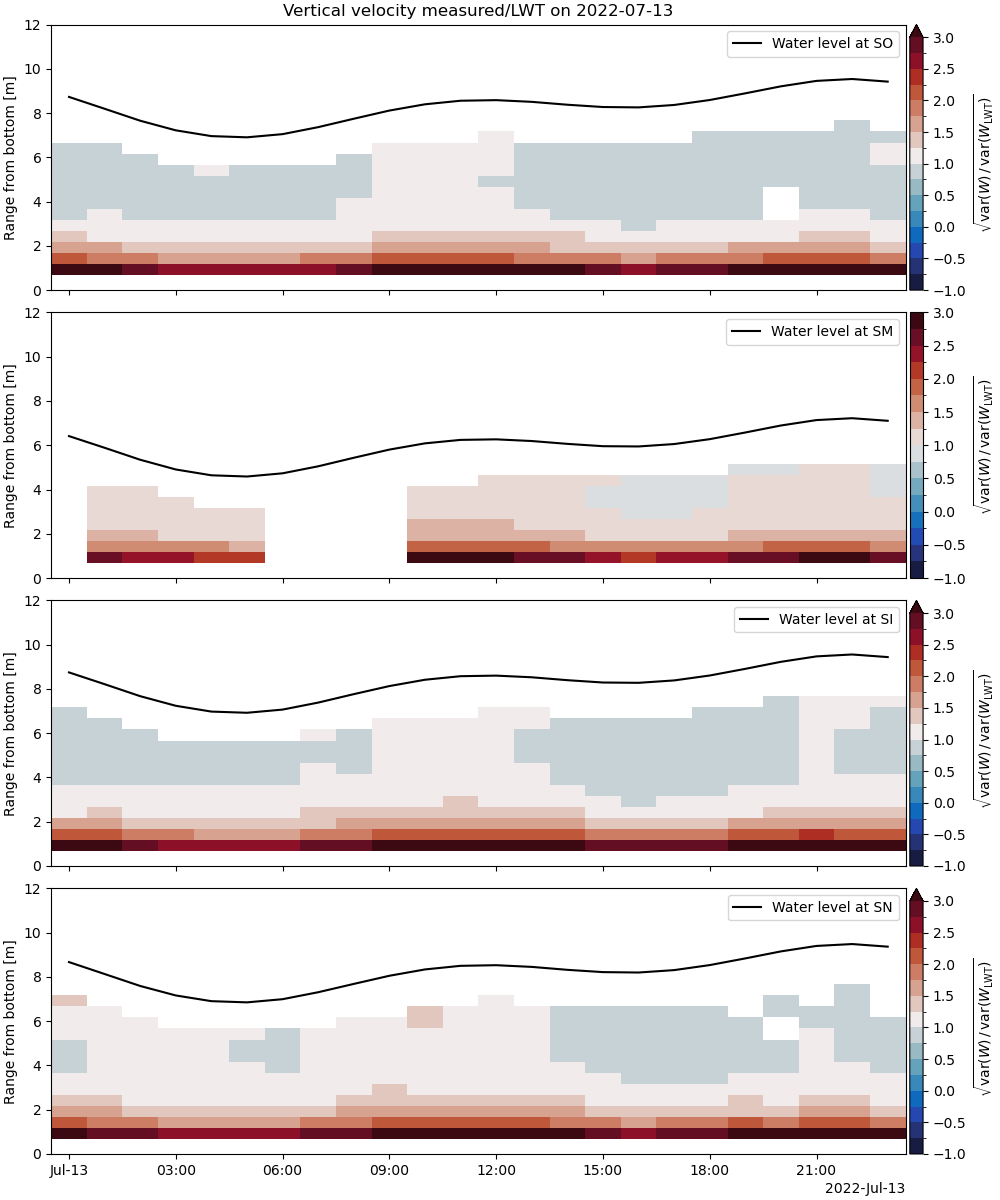

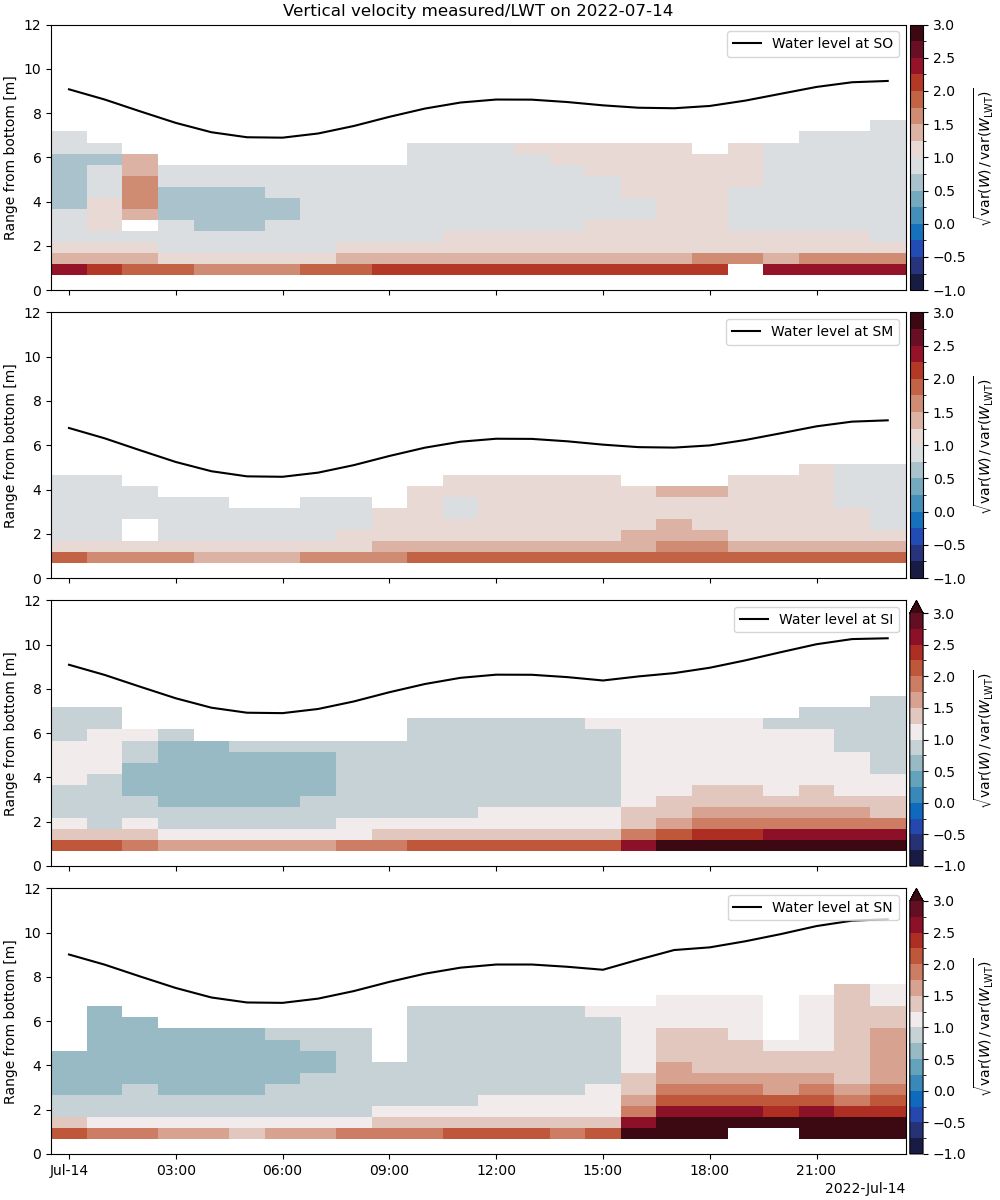

In [8]:
plt.clf()
plt.close()

# Date to plot
dates = pd.date_range('2022-07-05', '2022-07-14', freq='1d')
for date in tqdm(dates):
    # t0p = '2022-07-13'
    t0p = date.strftime('%Y-%m-%d')
    # Define serial numbers to plot and read netcdf file
    sers = ['103088', '103094', '103110', '103206']
    # Initialize figure
    fig, axes = plt.subplots(figsize=(10,12), nrows=4, sharex=True, sharey=True, constrained_layout=True)
    # ITerate over serial numbers
    for ser,ax in zip(sers,axes):
        # Read correct netcdf file
        mid = mids[ser]
        loc = sig_mids[mid]
        fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_20220705_20220714_max_amp_vel.nc')
        ds = xr.open_dataset(fn_nc, decode_coords='all')

        # Plot measured U_std vs LWT estimate
        # ax.plot(np.sqrt((ds.Uvar + ds.Vvar)).sel(time=t0p), ds.range)
        # Measured std(U)
        w_meas = np.sqrt(ds.Wvar).sel(time=t0p).copy()
        # LWT estimate
        k = ds.km.sel(time=t0p).copy()
        f = ds.fm.sel(time=t0p).copy()
        z = ds.range.copy()
        h = ds.depth.sel(time=t0p).copy()
        ASTvar = ds.ASTvar.sel(time=t0p).copy()
        w_lwt = np.sinh(k*z) / np.sinh(k*h) * np.sqrt(np.mean(ASTvar))*2*np.pi*f
        # Plot profiles of ratio of w_meas/w_lwt
        w_ratio = (w_meas/w_lwt)
        # Set min/max range for colormap
        vmax = abs(max(w_ratio.max().item(), w_ratio.min().item()))
        dv = vmax - 1
        # Plot
        #w_ratio.plot.pcolormesh(ax=ax, x='time', y='range', cmap=cmocean.cm.balance, vmin=1-dv, vmax=1+dv, levels=11)
        w_ratio.plot.pcolormesh(ax=ax, x='time', y='range', cmap=cmocean.cm.balance, 
                                vmin=-1, vmax=3, levels=17, cbar_kwargs={'pad':0.005,
                                                                        'label':r'$\sqrt{\mathrm{var}(W) \, / \, \mathrm{var}(W_\mathrm{LWT})}$'},
                                )
        ds.depth.sel(time=t0p).plot(ax=ax, c='k', label=f'Water level at {loc}')

        # Axis limits, labels, etc
        ax.set_ylim([0,12])
        ax.set_xlabel(None)
        ax.set_ylabel(f'Range from bottom [m]')
        ax.legend(loc='upper right')

    axes[0].set_title(f'Vertical velocity measured/LWT on {str(t0p)}')

    # Save or show
    figdir = os.path.join(sigdir, 'vel_vs_lwt')
    if not os.path.isdir(figdir):
        os.mkdir(figdir)
    datestr = pd.Timestamp(t0p).strftime('%Y%m%d')
    fn_fig = os.path.join(figdir, f'w_meas_vs_lwt_profiles_{datestr}_v2.png')
    # plt.show()
    if not os.path.isfile(fn_fig):
        print(f'Saving figure {fn_fig} ...')
        plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
        plt.close()
    else:
        plt.show()

Sample vertical timeseries of horizontal velocities from ADCP vs ADV.

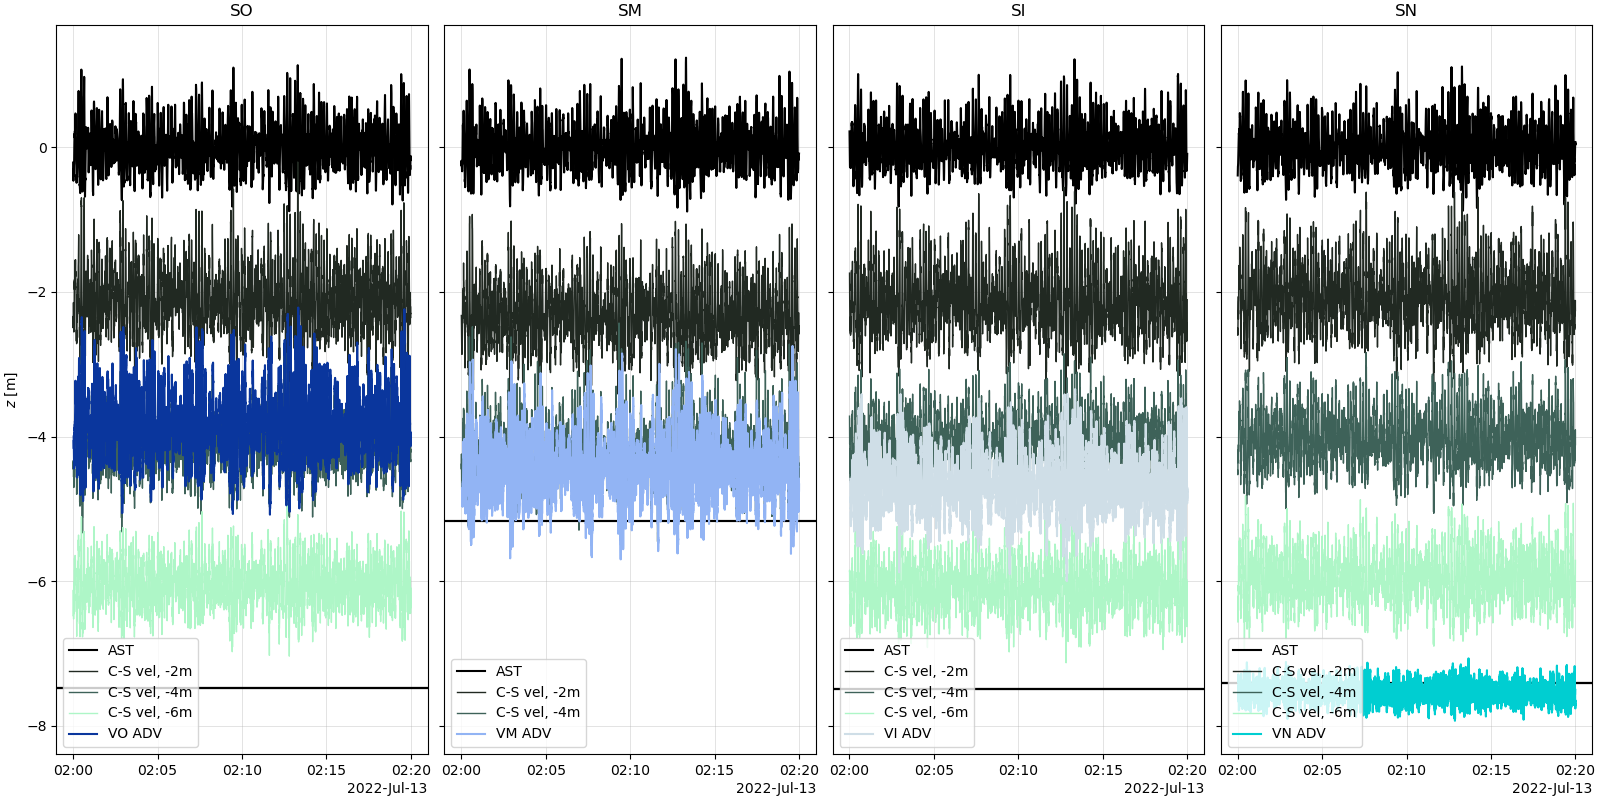

In [3]:
plt.clf()
plt.close()
t0 = pd.Timestamp('2022-07-13 02:00')
t1 = t0 + pd.Timedelta(minutes=20)
datestr = t0.strftime('%Y%m%d')
sers = ['103088', '103094', '103110', '103206']
# Vector IDs
midsv = {'6308':'L5', '17212':'C2', '17219':'C3', '17372':'C5'}
sersv = ['17212', '17219', '17372', '6308']
fig, axes = plt.subplots(figsize=(16,8), ncols=4, sharey=True, sharex=True,
                         constrained_layout=True)
# Use bathymetry to get location + MSL
bathydir = os.path.join(rootdir, 'Bathy') # Bathymetry dir.
fnb = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy_updated_1m.nc')
dsb = xr.open_dataset(fnb, decode_coords='all') # Bathymetry dataset
pc_root = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray'
# Beam vel. QC thresholds
amp_min = 40 # Beam amplitude minimum threshold (dB)
amp_max = 100 # Beam amplitude maximum threshold (dB)
vel_max = 3.0 # Beam velocity maximum threshold (m/s)
corr_thresh = 75 # Beam correlation minimum threshold (%)
# Plot timeseries
for (ser,serv,ax) in zip(sers,sersv,axes):
    sigdir = os.path.join(rootdir, 'Signatures')
    datadir = os.path.join(sigdir, 'Level1', ser)
    outdir = os.path.join(datadir, 'beam_vel')
    mid = mids[ser] # ADCP mooring ID
    loc = sig_mids[mid] 
    midv = midsv[serv] # ADV mooring ID
    # Read QC'd ADCP data
#     fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_20220705_20220714_max_amp_vel.nc')
#     ds = xr.open_dataset(fn_nc, decode_coords='all')

    # Read beam velocity dataset for current date
    fn_nc = os.path.join(datadir, f'Asilomar_SSA_Sig_Vel_{ser}_{datestr}_v2.nc')
    ds = xr.open_dataset(fn_nc)
    # Read old dataset with heading, pitch & roll
    fn_nc_2 = os.path.join(datadir, f'Asilomar_SSA_L1_Sig_Vel_{mid}_{datestr}.nc')
    ds2 = xr.open_dataset(fn_nc_2)
    ds2 = ds2[['vE', 'vN', 'vU2']].sel(time=slice(t0,t1))
    # Vector ADV data
    vec_root = os.path.join(rootdir, 'Vectors')
    vec_data = os.path.join(vec_root, 'Level1')
    vec_specdir = os.path.join(pc_root, 'Vectors')
    # Read Vector netcdf file
    ncdir = os.path.join(vec_data, midv)
    fn_vec = os.path.join(ncdir, f'Asilomar_SSA_L1_Vec_{serv}_{datestr}.nc')
    dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
    dsv = dsv.sel(time=slice(t0,t1))
    # Vector spectra file for depth
    fn_uspec_nc = os.path.join(vec_specdir, f'uspec_{midv}.nc')
    dsvs = xr.open_dataset(fn_uspec_nc, decode_coords='all')
    # Make masks for keeping only good values
    valid = (ds.range < (0.9 * ds.ASTd)) # Valid range values below surface
    good = {'B1': ((ds.ampB1>=amp_min) & (ds.ampB1<=amp_max) & (ds.vB1<=vel_max) & (ds.corrB1>=corr_thresh)), # Good Beam1 values
            'B2': ((ds.ampB2>=amp_min) & (ds.ampB1<=amp_max) & (ds.vB2<=vel_max) & (ds.corrB2>=corr_thresh)), # Good Beam2 values
            'B3': ((ds.ampB3>=amp_min) & (ds.ampB1<=amp_max) & (ds.vB3<=vel_max) & (ds.corrB3>=corr_thresh)), # Good Beam3 values
            'B4': ((ds.ampB4>=amp_min) & (ds.ampB1<=amp_max) & (ds.vB4<=vel_max) & (ds.corrB4>=corr_thresh)), # Good Beam4 values
            'B5': ((ds.ampB5>=amp_min) & (ds.ampB1<=amp_max) & (ds.vB5<=vel_max) & (ds.corrB5>=corr_thresh)), # Good Beam5 values
            }
    keys = ['vB1', 'vB2', 'vB3', 'vB4', 'vB5'] # Keys for beam vel.
    # Only keep valid/good beam velocities
    seg = ds[keys].where((valid & good['B1'] & good['B2'] & good['B3'] & good['B4'] & good['B5'])).sel(time=slice(t0,t1)).copy()
    # Rotate East, North velocities to cross-/alongshore vel.
    ui = ds2.vE.values
    vi = ds2.vN.values
    # Rotation angle (use ROXSI LSA reference angle from bathy)
    ref_ang = int(dsb.attrs['reference_angle'][:3])
    angle_math = 270 - ref_ang
    if angle_math < 0:
        angle_math += 360
    angle_math = np.deg2rad(angle_math) # radians
    # Initialize cross-/longshore velocity arrays
    ul = np.ones_like(ui) * np.nan # Cross-shore vel.
    vl = np.ones_like(vi) * np.nan # Along-shore vel.
    # Rotate at each range level
    for i,r in enumerate(seg.range.values):
        # Copy E, N velocity components
        ur = ds2.vE.sel(range=r).values.copy()
        vr = ds2.vN.sel(range=r).values.copy()
        # Rotate
        ul[:,i], vl[:,i] = rpct.rotate_vel(ur, vr, angle_math)
    # Save rotated velocities in dataset segment 
    seg['vCS'] = (['time', 'range'], ul)
    seg['vLS'] = (['time', 'range'], vl)
    # AST signal
    ast = ds.ASTd.sel(time=slice(t0,t1)).copy()
    depth = ast.mean().item()
    # Plot AST range
    ax.plot(seg.time, detrend(ast), c='k', label='AST')
    # Iterate over set vertical levels below mean surface level
    rs = [] # To check that we're not plotting the same depth level more than once
    # cs = ['#212922', '#294936', '#3E6259', '#5B8266', '#AEF6C7']
    cs = ['#212922','#3E6259','#AEF6C7']
    for iz,zlev in enumerate([2, 4, 6,]):
        rz = seg.sel(range=(depth-zlev), method='nearest').range.item() # Nearest range bin
        if not rz in rs:
            # Calculate E,N,U velocities from beam velocities
            # Note order and sign of beams!!!
    #         print('Converting ...')
    #         beam_arr = np.array([-seg.vB1.values, -seg.vB3.values, -seg.vB4.values, -seg.vB2.values, -seg.vB5.values])
    #         enu_vel = rpct.beam2enu(beam_arr, heading=ds2.heading_ang.values, pitch=ds2.pitch_ang.values, roll=ds2.roll_ang.values)

            # Plot cross-shore vel.
            (-(depth-rz) + seg.vCS.sel(range=rz)).plot(ax=ax, label=f'C-S vel, -{zlev}m', c=cs[iz], alpha=1.0, lw=1.0)

            # Plot mean depth horizontal line
            ax.axhline(-depth, c='k')
        # Append rz to list to avoid plotting same depth level twice
        rs.append(rz)
    # Plot near-bed Vector ADV velocity profile
    # (dsv.ucs-dsvs.depth_loc.sel(time=t0, method='nearest').item()).plot(ax=ax)
    depth_vec = dsv.z_hyd.mean().item()
    (dsv.ucs-depth_vec+0.5).plot(ax=ax, c=clsv[midv], label=f'{vec_mids[midv]} ADV')

    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(loc)
    ax.grid(alpha=0.5, lw=0.5)
    ax.legend(ncols=1, loc='lower left')
#     t0p = pd.Timestamp('2022-07-13 03:11:30')
#     t1p = t0p + pd.Timedelta(minutes=1)
#     ax.set_xlim([t0p, t1p])
axes[0].set_ylabel(r'$z$ [m]')

plt.show()



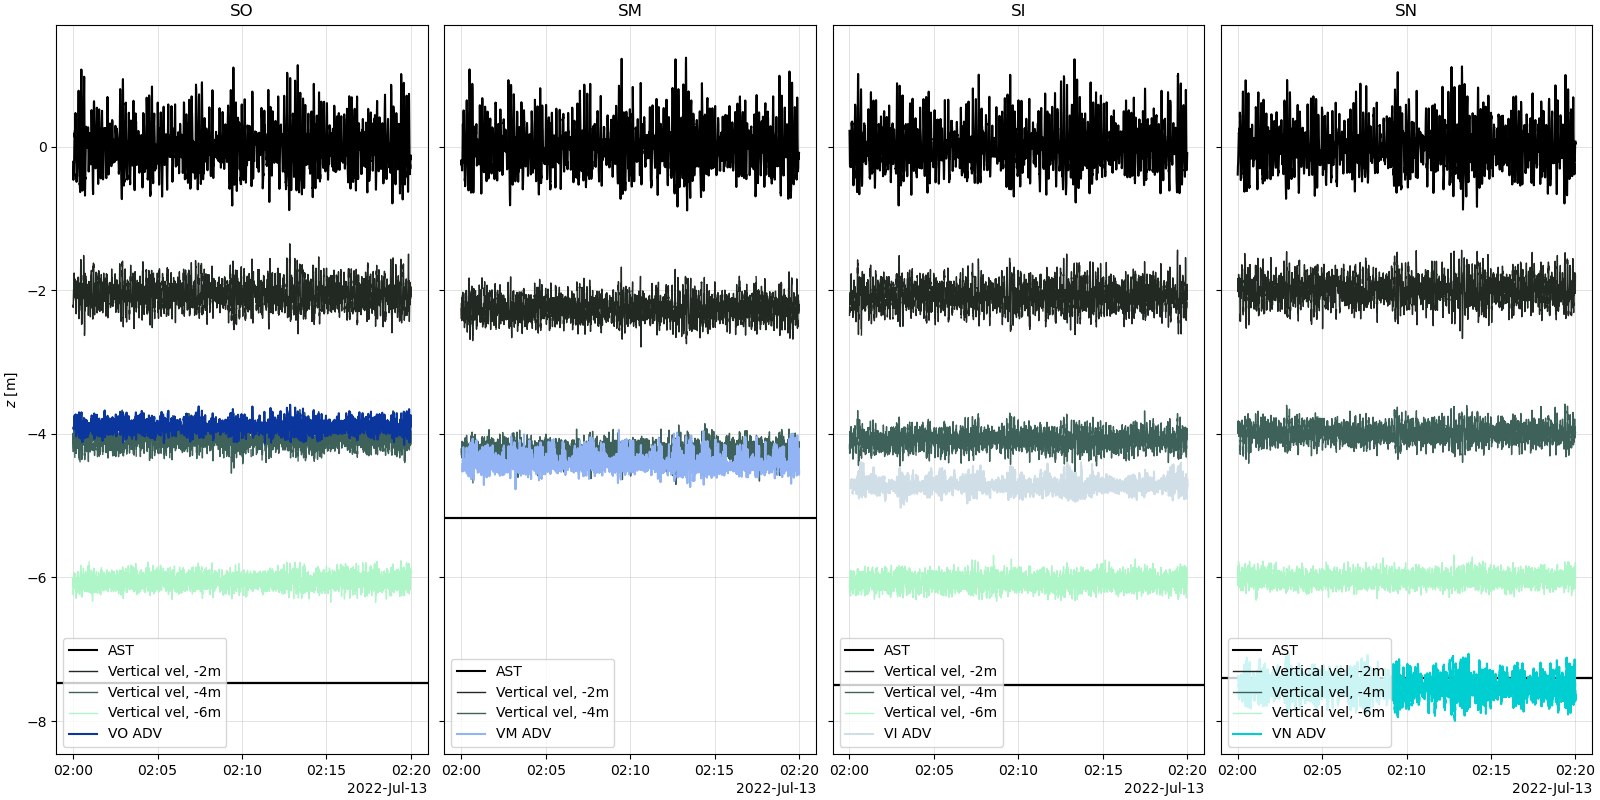

In [6]:
# Same for vertical velocities
plt.clf()
plt.close()
t0 = pd.Timestamp('2022-07-13 02:00')
t1 = t0 + pd.Timedelta(minutes=20)
datestr = t0.strftime('%Y%m%d')
sers = ['103088', '103094', '103110', '103206']
# Vector IDs
midsv = {'6308':'L5', '17212':'C2', '17219':'C3', '17372':'C5'}
sersv = ['17212', '17219', '17372', '6308']
fig, axes = plt.subplots(figsize=(16,8), ncols=4, sharey=True, sharex=True,
                         constrained_layout=True)
# Use bathymetry to get location + MSL
bathydir = os.path.join(rootdir, 'Bathy') # Bathymetry dir.
fnb = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy_updated_1m.nc')
dsb = xr.open_dataset(fnb, decode_coords='all') # Bathymetry dataset
pc_root = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray'
# Beam vel. QC thresholds
amp_min = 40 # Beam amplitude minimum threshold (dB)
amp_max = 100 # Beam amplitude maximum threshold (dB)
vel_max = 3.0 # Beam velocity maximum threshold (m/s)
corr_thresh = 75 # Beam correlation minimum threshold (%)
# Plot timeseries
for (ser,serv,ax) in zip(sers,sersv,axes):
    sigdir = os.path.join(rootdir, 'Signatures')
    datadir = os.path.join(sigdir, 'Level1', ser)
    outdir = os.path.join(datadir, 'beam_vel')
    mid = mids[ser] # ADCP mooring ID
    loc = sig_mids[mid] 
    midv = midsv[serv] # ADV mooring ID
    # Read QC'd ADCP data
#     fn_nc = os.path.join(sigdir, f'{ser}_vel_stats_20220705_20220714_max_amp_vel.nc')
#     ds = xr.open_dataset(fn_nc, decode_coords='all')

    # Read beam velocity dataset for current date
    fn_nc = os.path.join(datadir, f'Asilomar_SSA_Sig_Vel_{ser}_{datestr}_v2.nc')
    ds = xr.open_dataset(fn_nc)
    # Read old dataset with heading, pitch & roll
    fn_nc_2 = os.path.join(datadir, f'Asilomar_SSA_L1_Sig_Vel_{mid}_{datestr}.nc')
    ds2 = xr.open_dataset(fn_nc_2)
    ds2 = ds2[['vE', 'vN', 'vU2']].sel(time=slice(t0,t1))
    # Vector ADV data
    vec_root = os.path.join(rootdir, 'Vectors')
    vec_data = os.path.join(vec_root, 'Level1')
    vec_specdir = os.path.join(pc_root, 'Vectors')
    # Read Vector netcdf file
    ncdir = os.path.join(vec_data, midv)
    fn_vec = os.path.join(ncdir, f'Asilomar_SSA_L1_Vec_{serv}_{datestr}.nc')
    dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
    dsv = dsv.sel(time=slice(t0,t1))
    # Vector spectra file for depth
    fn_uspec_nc = os.path.join(vec_specdir, f'uspec_{midv}.nc')
    dsvs = xr.open_dataset(fn_uspec_nc, decode_coords='all')
    # Make masks for keeping only good values
    valid = (ds.range < (0.9 * ds.ASTd)) # Valid range values below surface
    good = {'B1': ((ds.ampB1>=amp_min) & (ds.ampB1<=amp_max) & (ds.vB1<=vel_max) & (ds.corrB1>=corr_thresh)), # Good Beam1 values
            'B2': ((ds.ampB2>=amp_min) & (ds.ampB1<=amp_max) & (ds.vB2<=vel_max) & (ds.corrB2>=corr_thresh)), # Good Beam2 values
            'B3': ((ds.ampB3>=amp_min) & (ds.ampB1<=amp_max) & (ds.vB3<=vel_max) & (ds.corrB3>=corr_thresh)), # Good Beam3 values
            'B4': ((ds.ampB4>=amp_min) & (ds.ampB1<=amp_max) & (ds.vB4<=vel_max) & (ds.corrB4>=corr_thresh)), # Good Beam4 values
            'B5': ((ds.ampB5>=amp_min) & (ds.ampB1<=amp_max) & (ds.vB5<=vel_max) & (ds.corrB5>=corr_thresh)), # Good Beam5 values
            }
    keys = ['vB1', 'vB2', 'vB3', 'vB4', 'vB5'] # Keys for beam vel.
    # Only keep valid/good beam velocities
    seg = ds[keys].where((valid & good['B1'] & good['B2'] & good['B3'] & good['B4'] & good['B5'])).sel(time=slice(t0,t1)).copy()
    # Rotate East, North velocities to cross-/alongshore vel.
    ui = ds2.vE.values
    vi = ds2.vN.values
    # Rotation angle (use ROXSI LSA reference angle from bathy)
    ref_ang = int(dsb.attrs['reference_angle'][:3])
    angle_math = 270 - ref_ang
    if angle_math < 0:
        angle_math += 360
    angle_math = np.deg2rad(angle_math) # radians
    # Initialize cross-/longshore velocity arrays
    ul = np.ones_like(ui) * np.nan # Cross-shore vel.
    vl = np.ones_like(vi) * np.nan # Along-shore vel.
    # Rotate at each range level
    for i,r in enumerate(seg.range.values):
        # Copy E, N velocity components
        ur = ds2.vE.sel(range=r).values.copy()
        vr = ds2.vN.sel(range=r).values.copy()
        # Rotate
        ul[:,i], vl[:,i] = rpct.rotate_vel(ur, vr, angle_math)
    # Save rotated velocities in dataset segment 
    seg['vCS'] = (['time', 'range'], ul)
    seg['vLS'] = (['time', 'range'], vl)
    # AST signal
    ast = ds.ASTd.sel(time=slice(t0,t1)).copy()
    depth = ast.mean().item()
    # Plot AST range
    ax.plot(seg.time, detrend(ast), c='k', label='AST')
    # Iterate over set vertical levels below mean surface level
    rs = [] # To check that we're not plotting the same depth level more than once
    # cs = ['#212922', '#294936', '#3E6259', '#5B8266', '#AEF6C7']
    cs = ['#212922','#3E6259','#AEF6C7']
    for iz,zlev in enumerate([2, 4, 6,]):
        rz = seg.sel(range=(depth-zlev), method='nearest').range.item() # Nearest range bin
        if not rz in rs:
            # Calculate E,N,U velocities from beam velocities
            # Note order and sign of beams!!!
    #         print('Converting ...')
    #         beam_arr = np.array([-seg.vB1.values, -seg.vB3.values, -seg.vB4.values, -seg.vB2.values, -seg.vB5.values])
    #         enu_vel = rpct.beam2enu(beam_arr, heading=ds2.heading_ang.values, pitch=ds2.pitch_ang.values, roll=ds2.roll_ang.values)

            # Plot cross-shore vel.
            (-(depth-rz) + seg.vB5.sel(range=rz)).plot(ax=ax, label=f'Vertical vel, -{zlev}m', c=cs[iz], alpha=1.0, lw=1.0)

            # Plot mean depth horizontal line
            ax.axhline(-depth, c='k')
        # Append rz to list to avoid plotting same depth level twice
        rs.append(rz)
    # Plot near-bed Vector ADV velocity profile
    # (dsv.ucs-dsvs.depth_loc.sel(time=t0, method='nearest').item()).plot(ax=ax)
    depth_vec = dsv.z_hyd.mean().item()
    (dsv.uU-depth_vec+0.5).plot(ax=ax, c=clsv[midv], label=f'{vec_mids[midv]} ADV')

    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(loc)
    ax.grid(alpha=0.5, lw=0.5)
    ax.legend(ncols=1, loc='lower left')
#     t0p = pd.Timestamp('2022-07-13 03:11:30')
#     t1p = t0p + pd.Timedelta(minutes=1)
#     ax.set_xlim([t0p, t1p])
axes[0].set_ylabel(r'$z$ [m]')

plt.show()



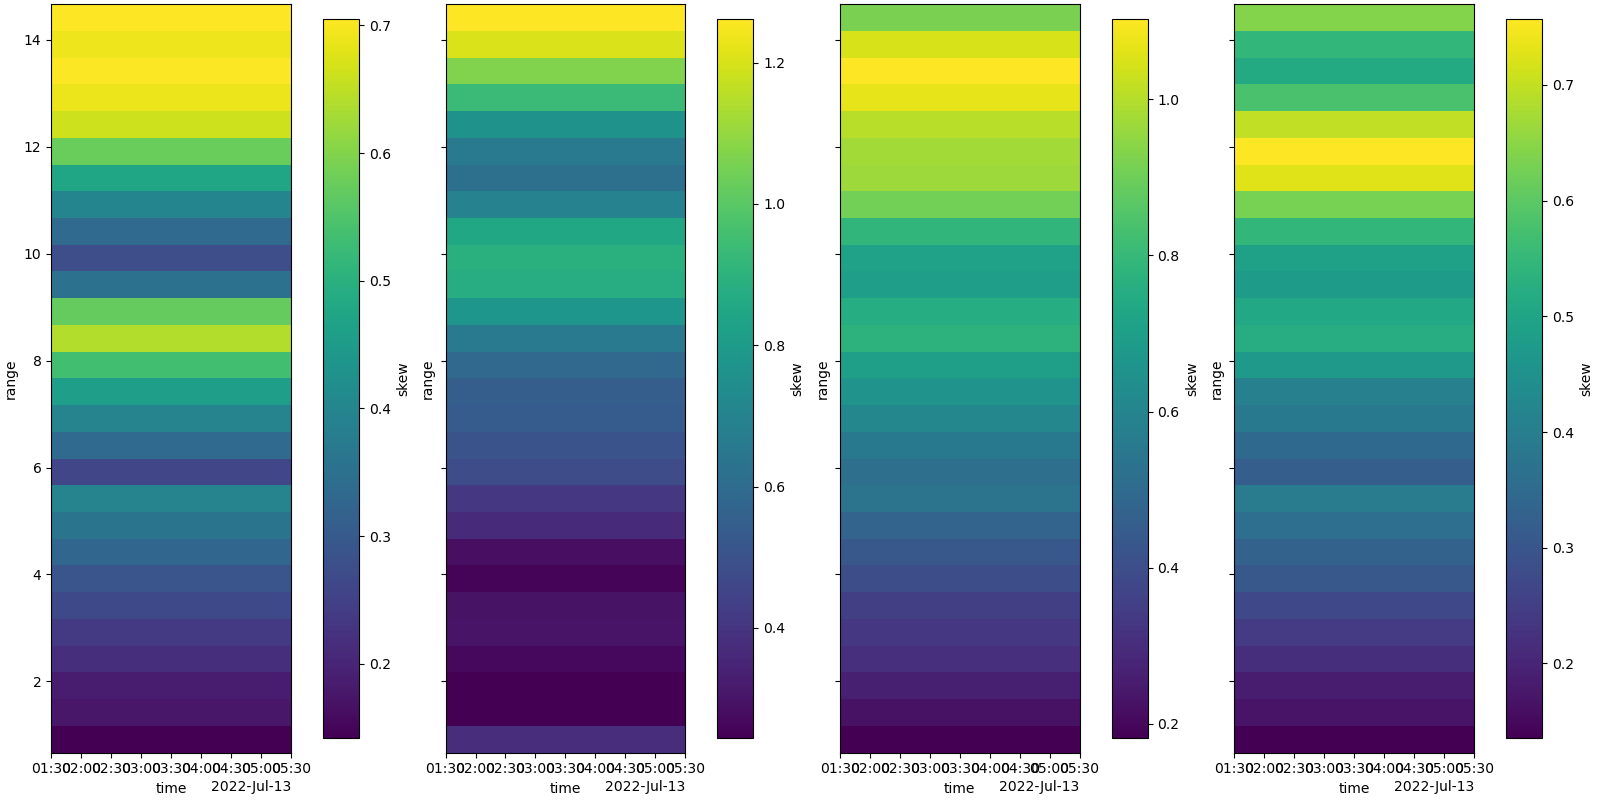

In [4]:
# Skewness profile
plt.clf()
plt.close()
t0 = pd.Timestamp('2022-07-13 02:00')
t1 = pd.Timestamp('2022-07-13 05:00')
datestr = t0.strftime('%Y%m%d')
sers = ['103088', '103094', '103110', '103206']
fig, axes = plt.subplots(figsize=(16,8), ncols=4, sharey=True, sharex=True,
                         constrained_layout=True)
# Plot timeseries
for (ser,ax) in zip(sers,axes):
    sigdir = os.path.join(rootdir, 'Signatures')
    datadir = os.path.join(sigdir, 'Level1', ser)
    outdir = os.path.join(datadir, 'beam_vel')
    mid = mids[ser] # ADCP mooring ID
    loc = sig_mids[mid] 
    midv = midsv[serv] # ADV mooring ID
    # Read beam velocity dataset for current date
    fn_nc = os.path.join(datadir, f'Asilomar_SSA_Sig_Vel_{ser}_{datestr}_v2.nc')
    # ds = xr.open_dataset(fn_nc)
    # Read old dataset with vE & vN
    fn_nc_2 = os.path.join(datadir, f'Asilomar_SSA_L1_Sig_Vel_{mid}_{datestr}.nc')
    ds2 = xr.open_dataset(fn_nc_2, decode_coords='all')
    dsl = []
    dr = pd.date_range(t0,t1+pd.Timedelta(hours=1),freq='1h')
    for t0s,t1s in zip(dr[:-1],dr[1:]):
        seg = ds2[['vE','vN']].sel(time=slice(t0,t1)).copy()
        # Rotate East, North velocities to cross-/alongshore vel.
        ui = seg.vE.values
        vi = seg.vN.values
        # Rotation angle (use ROXSI LSA reference angle from bathy)
        ref_ang = int(dsb.attrs['reference_angle'][:3])
        angle_math = 270 - ref_ang
        if angle_math < 0:
            angle_math += 360
        angle_math = np.deg2rad(angle_math) # radians
        # Initialize cross-/longshore velocity arrays
        ul = np.ones_like(ui) * np.nan # Cross-shore vel.
        vl = np.ones_like(vi) * np.nan # Along-shore vel.
        sk = np.ones(len(seg.range.values)) * np.nan # C-S skewness
        # Rotate at each range level
        for i,r in enumerate(seg.range.values):
            # Copy E, N velocity components
            ur = seg.vE.sel(range=r).values.copy()
            vr = seg.vN.sel(range=r).values.copy()
            # Rotate
            ul[:,i], vl[:,i] = rpct.rotate_vel(ur, vr, angle_math)
            sk[i] = skew(ul[:,i])
        # Save rotated velocities in dataset segment 
        seg['vCS'] = (['time', 'range'], ul)
        seg['vLS'] = (['time', 'range'], vl)
        da = xr.Dataset(
            data_vars=dict(
                skew=(["range"],sk),
            ),
            coords=dict(
                range=("range", seg.range.values),
            ),
        )
        da = da.assign_coords(time=[t0s])
        dsl.append(da)
    segn = xr.concat(dsl,dim='time')

    segn['skew'].plot(ax=ax, x='time', y='range')

NameError: name 'dsd' is not defined

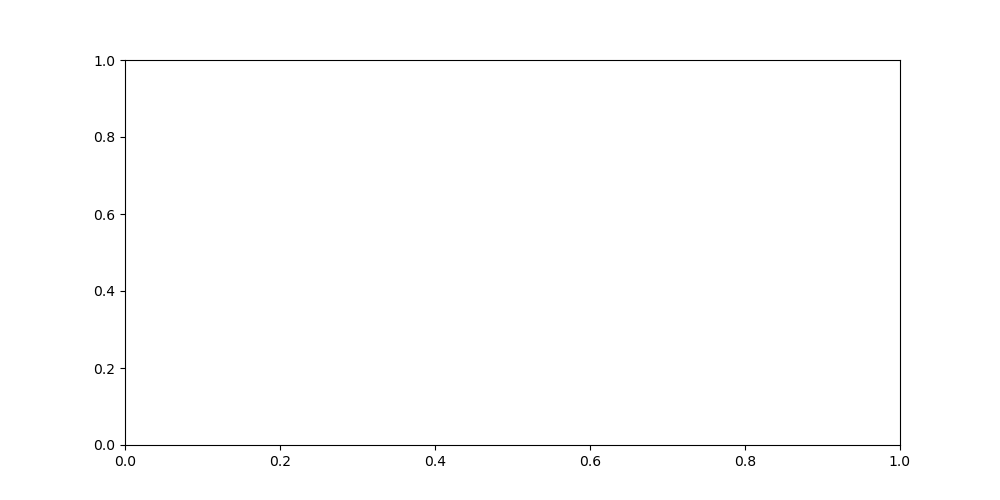

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
dsd['vB1'].isel(time=1).Ezz.plot(ax=ax, x='freq', y='range')
plt.show()